In [1]:
import numpy as np
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as ptchs
from matplotlib import gridspec
import matplotlib.text as mtext

import scipy.integrate
import scipy.optimize
from sklearn.linear_model import Ridge

import pandas as pd
from pandas.core.base import PandasObject

system = "das6"
vd_input_folder = f"{system}-gpu/"
mb_input_folder = f"../microbenchmarks/{system}/"
output_folder = f"../../images/{system}"
%run ../notebook_setup.ipynb

In [2]:
a4000_maxsmem = 49152 # 48 KB
a4000_l2_size = 4194304 # 48 KB
a4000_l2_persistent_size = 3145728 # 48 KB

# Validation Data

In [3]:
validation_results = "das6-gpu/validation" 
validation_df = pd.read_csv(validation_results)
validation_df["nvals"] =  validation_df["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
validation_df["distribution"] = validation_df["input"].apply(lambda s: s.split("_")[1])
validation_df["env"] = validation_df["env"].apply(map_env)
convert_to_type(validation_df, "edges", np.bool_)
convert_to_type(validation_df, "nvals", np.int64)
convert_to_type(validation_df, "nbins", np.int64)
del validation_df["input"]
validation_df

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,1.291421,50000000,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,2.370882,100000000,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,7.550797,500000000,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,19.217439,1000000000,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,1.386995,50000000,normal-0.7-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,4,CUDA,A4000,86,10000000,134217728,False,256,0.0,0.0,0.0,11.842449,1000000000,uniform
5756,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,0.562519,50000000,uniform
5757,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,1.037599,100000000,uniform
5758,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,4.794870,500000000,uniform


In [4]:
groupby_list = ["env", "gpu", "distribution", "nvals", "nbins", "bulksize", "edges"]

In [5]:
gp_vd = validation_df.groupby([*groupby_list])
gp_vd.mean()

iter    cc  \
env  gpu   distribution nvals      nbins    bulksize  edges               
CUDA A4000 constant-0.5 50000000   10       8192      False   2.0  86.0   
                                                      True    2.0  86.0   
                                            16384     False   2.0  86.0   
                                                      True    2.0  86.0   
                                            32768     False   2.0  86.0   
...                                                           ...   ...   
           uniform      1000000000 10000000 2097152   True    2.0  86.0   
                                            16777216  False   2.0  86.0   
                                                      True    2.0  86.0   
                                            134217728 False   2.0  86.0   
                                                      True    2.0  86.0   

                                                             blocksize  \
env  gpu   distribution nvals      nbins    bulksize  edges              
CUDA A4000 constant-0.5 50000000   10       8192      False      256.0   
                                                      True       256.0   
                                            16384     False      256.0   
                                                      True       256.0   
                                            32768     False      256.0   
...                                                                ...   
           uniform      1000000000 10000000 2097152   True       256.0   
                                            16777216  False      256.0   
                                                      True       256.0   
                                            134217728 False      256.0   
                                                      True       256.0   

                                                             tfindbin  tfill  \
env  gpu   distribution nvals      nbins    bulksize  edges                    
CUDA A4000 constant-0.5 50000000   10       8192      False       0.0    0.0   
                                                      True        0.0    0.0   
                                            16384     False       0.0    0.0   
                                                      True        0.0    0.0   
                                            32768     False       0.0    0.0   
...                                                               ...    ...   
           uniform      1000000000 10000000 2097152   True        0.0    0.0   
                                            16777216  False       0.0    0.0   
                                                      True        0.0    0.0   
                                            134217728 False       0.0    0.0   
                                                      True        0.0    0.0   

                                                             tstats     ttotal  
env  gpu   distribution nvals      nbins    bulksize  edges                     
CUDA A4000 constant-0.5 50000000   10       8192      False     0.0   1.052795  
                                                      True      0.0   1.004725  
                                            16384     False     0.0   0.862259  
                                                      True      0.0   0.839961  
                                            32768     False     0.0   0.763279  
...                                                             ...        ...  
           uniform      1000000000 10000000 2097152   True      0.0  11.213498  
                                            16777216  False     0.0   9.874719  
                                                      True      0.0   9.937786  
                                            134217728 False     0.0   9.973750  
                                                      True      0.0   9.939815  

[1152 rows x 7 columns]

In [6]:
vd_unique_env = validation_df["env"].unique()
vd_unique_bulksize = np.sort(validation_df["bulksize"].unique())
vd_unique_nbins = np.sort(validation_df["nbins"].unique())
vd_unique_nvals = np.sort(validation_df["nvals"].unique().astype(np.float64))
vd_unique_gpus = validation_df["gpu"].unique()
vd_unique_distributions = validation_df["distribution"].unique()
vd_unique_edges = [True, False]
vd_unique_env, vd_unique_gpus, vd_unique_nbins, vd_unique_bulksize, vd_unique_edges, vd_unique_nvals, vd_unique_distributions

(array(['CUDA'], dtype=object),
 array(['A4000'], dtype=object),
 array([      10,     1000,   100000, 10000000]),
 array([     8192,     16384,     32768,     65536,    131072,    262144,
          2097152,  16777216, 134217728]),
 [True, False],
 array([5.e+07, 1.e+08, 5.e+08, 1.e+09]),
 array(['normal-0.4-0.1', 'normal-0.7-0.01', 'constant-0.5', 'uniform'],
       dtype=object))

In [7]:
nsys_validation_results = "das6-gpu/nsys-validation" 
api_buf = pd.read_csv(f"{nsys_validation_results}/api")
api_buf["nvals"] =  api_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
api_buf["distribution"] =  api_buf["input"].apply(lambda s: s.split("_")[1])
api_buf["env"] = api_buf["env"].apply(map_env)
convert_to_type(api_buf, "edges", np.bool_)
del api_buf["input"]
api_buf

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,Time (%),Total Time (ns),Num Calls,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Name,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,49.0,448620130,61080,7344.8,6602.0,5691,36650198,148276.8,cudaLaunchKernel,5.000000e+07,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,24.6,225013621,12222,18410.5,20608.5,6121,528369,8181.6,cudaMemcpy,5.000000e+07,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,20.8,190855173,10,19085517.3,7243.5,4088,190793145,60331910.6,cudaMalloc,5.000000e+07,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,5.6,50940094,6110,8337.2,8185.0,4348,72095,1551.9,cudaMemset,5.000000e+07,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,0.1,481281,10,48128.1,6276.5,4188,409526,127133.1,cudaFree,5.000000e+07,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40315,4,CUDA,A4000,86,10000000,134217728,True,256,2.4,30812779,950,32434.5,5069.0,3486,24981135,810304.9,cudaLaunchKernel,1.000000e+09,uniform
40316,4,CUDA,A4000,86,10000000,134217728,True,256,0.7,9209560,11,837232.7,306313.0,2735,2780602,1060177.0,cudaFree,1.000000e+09,uniform
40317,4,CUDA,A4000,86,10000000,134217728,True,256,0.3,3181329,97,32797.2,31659.0,5901,75301,5801.8,cudaMemset,1.000000e+09,uniform
40318,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,124182,1,124182.0,124182.0,124182,124182,0.0,cudaGetDeviceProperties_v2_v12000,1.000000e+09,uniform


In [8]:
gp_api = api_buf.groupby([*groupby_list, "Name"])
gp_api.mean()

iter  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                      
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False cuModuleGetLoadingMode              2.0   
                                                              cudaFree                            2.0   
                                                              cudaGetDeviceProperties_v2_v12000   2.0   
                                                              cudaLaunchKernel                    2.0   
                                                              cudaMalloc                          2.0   
...                                                                                               ...   
           uniform      1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000   2.0   
                                                              cudaLaunchKernel                    2.0   
                                                              cudaMalloc                          2.0   
                                                              cudaMemcpy                          2.0   
                                                              cudaMemset                          2.0   

                                                                                                   cc  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                      
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False cuModuleGetLoadingMode             86.0   
                                                              cudaFree                           86.0   
                                                              cudaGetDeviceProperties_v2_v12000  86.0   
                                                              cudaLaunchKernel                   86.0   
                                                              cudaMalloc                         86.0   
...                                                                                               ...   
           uniform      1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000  86.0   
                                                              cudaLaunchKernel                   86.0   
                                                              cudaMalloc                         86.0   
                                                              cudaMemcpy                         86.0   
                                                              cudaMemset                         86.0   

                                                                                                 blocksize  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                           
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False cuModuleGetLoadingMode                 256.0   
                                                              cudaFree                               256.0   
                                                              cudaGetDeviceProperties_v2_v12000      256.0   
                                                              cudaLaunchKernel                       256.0   
                                                              cudaMalloc                             256.0   
...                                                                                                    ...   
           uniform      1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000      256.0   
                                                              cudaLaunchKernel                       256.0   
                                                              cudaMalloc                             256.0   
                                                              cudaMemcpy                             256.0   
                                             

In [9]:
kernel_buf = pd.read_csv(f"{nsys_validation_results}/kernel")
kernel_buf["nvals"] =  kernel_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
kernel_buf["distribution"] =  kernel_buf["input"].apply(lambda s: s.split("_")[1])
kernel_buf["env"] = kernel_buf["env"].apply(map_env)
convert_to_type(kernel_buf, "edges", np.bool_)
del kernel_buf["input"]
kernels_unfiltered = kernel_buf.copy()
kernel_buf["Name"] = kernel_buf["Name"].apply(filter_name)
kernel_buf

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,Time (%),Total Time (ns),Instances,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Name,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,32.7,145665865,6108,23848.4,23776.0,21825,26880,578.2,FindBin + AddBinContent,5.000000e+07,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,29.9,133215898,24404,5458.8,5472.0,5407,5568,22.1,UpdateStats,5.000000e+07,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,8.7,38912425,6101,6378.0,6368.0,6303,6625,29.8,UpdateStats,5.000000e+07,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,8.2,36472816,6101,5978.2,5984.0,5888,6304,30.1,UpdateStats,5.000000e+07,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,8.1,36149959,6101,5925.3,5920.0,5855,6208,29.2,UpdateStats,5.000000e+07,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69075,4,CUDA,A4000,86,10000000,134217728,True,256,1.2,39659731,95,417470.9,418945.0,148673,494945,28988.6,UpdateStats,1.000000e+09,uniform
69076,4,CUDA,A4000,86,10000000,134217728,True,256,1.2,39568751,95,416513.2,418337.0,148160,494081,28905.9,UpdateStats,1.000000e+09,uniform
69077,4,CUDA,A4000,86,10000000,134217728,True,256,0.6,20582057,95,216653.2,217536.0,81888,256097,14526.4,UpdateStats,1.000000e+09,uniform
69078,4,CUDA,A4000,86,10000000,134217728,True,256,0.6,20061093,95,211169.4,211936.0,76544,250368,14537.3,UpdateStats,1.000000e+09,uniform


In [10]:
gp_kernels = kernel_buf.groupby([*groupby_list, "iter", "Name"], as_index=False).sum()
gp_kernels = gp_kernels.groupby([*groupby_list, "Name"])
gp_kernels_unfiltered = kernels_unfiltered.groupby([*groupby_list, "Name"])
gp_kernels.mean()

iter  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                            
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent   2.0   
                                                              Other                     2.0   
                                                              UpdateStats               2.0   
                                                        True  FindBin + AddBinContent   2.0   
                                                              Other                     2.0   
...                                                                                     ...   
           uniform      1.000000e+09 10000000 134217728 False Other                     2.0   
                                                              UpdateStats               2.0   
                                                        True  FindBin + AddBinContent   2.0   
                                                              Other                     2.0   
                                                              UpdateStats               2.0   

                                                                                          cc  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                             
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent   86.0   
                                                              Other                     86.0   
                                                              UpdateStats              860.0   
                                                        True  FindBin + AddBinContent   86.0   
                                                              Other                     86.0   
...                                                                                      ...   
           uniform      1.000000e+09 10000000 134217728 False Other                     86.0   
                                                              UpdateStats              430.0   
                                                        True  FindBin + AddBinContent   86.0   
                                                              Other                     86.0   
                                                              UpdateStats              430.0   

                                                                                       blocksize  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                 
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent      256.0   
                                                              Other                        256.0   
                                                              UpdateStats                 2560.0   
                                                        True  FindBin + AddBinContent      256.0   
                                                              Other                        256.0   
...                                                                                          ...   
           uniform      1.000000e+09 10000000 134217728 False Other                        256.0   
                                                              UpdateStats                 1280.0   
                                                        True  FindBin + AddBinContent      256.0   
                                                              Other                        256.0   
                                                              UpdateStats                 1280.0   

                                                                                       Time (%)  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent     50.96   
    

In [11]:
memops_buf = pd.read_csv(f"{nsys_validation_results}/memop")
memops_buf["nvals"] =  memops_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
memops_buf["distribution"] =  memops_buf["input"].apply(lambda s: s.split("_")[1])
memops_buf["env"] = memops_buf["env"].apply(map_env)
convert_to_type(memops_buf, "edges", np.bool_)
del memops_buf["input"]
memops_buf["Operation"] = memops_buf["Operation"].apply(filter_name)
memops_buf

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,Time (%),Total Time (ns),Count,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Operation,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,86.1,107810209,12220,8822.4,9024.0,896,9504,433.3,HtoD,5.000000e+07,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,13.9,17462218,6110,2858.0,2848.0,896,3360,66.7,CUDA memset,5.000000e+07,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,0.0,3744,2,1872.0,1872.0,1856,1888,22.6,DtoH,5.000000e+07,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,84.2,142574435,24440,5833.7,5792.0,512,6752,236.5,HtoD,1.000000e+08,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,15.8,26832872,12220,2195.8,2208.0,512,2752,58.8,CUDA memset,1.000000e+08,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,4,CUDA,A4000,86,10000000,134217728,True,256,1.4,7507431,2,3753715.5,3753715.5,1760,7505671,5306066.4,DtoH,5.000000e+08,uniform
17276,4,CUDA,A4000,86,10000000,134217728,True,256,0.3,1412249,50,28245.0,25599.0,929,197600,24897.3,CUDA memset,5.000000e+08,uniform
17277,4,CUDA,A4000,86,10000000,134217728,True,256,99.0,1020098498,195,5231274.3,5357065.0,416,7229229,950540.9,HtoD,1.000000e+09,uniform
17278,4,CUDA,A4000,86,10000000,134217728,True,256,0.7,7467215,2,3733607.5,3733607.5,1344,7465871,5278217.7,DtoH,1.000000e+09,uniform


In [12]:
gp_memops = memops_buf.groupby([*groupby_list, "Operation"])
gp_memops.mean()

iter  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation           
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset   2.0   
                                                              DtoH          2.0   
                                                              HtoD          2.0   
                                                        True  CUDA memset   2.0   
                                                              DtoH          2.0   
...                                                                         ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH          2.0   
                                                              HtoD          2.0   
                                                        True  CUDA memset   2.0   
                                                              DtoH          2.0   
                                                              HtoD          2.0   

                                                                             cc  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation           
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset  86.0   
                                                              DtoH         86.0   
                                                              HtoD         86.0   
                                                        True  CUDA memset  86.0   
                                                              DtoH         86.0   
...                                                                         ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH         86.0   
                                                              HtoD         86.0   
                                                        True  CUDA memset  86.0   
                                                              DtoH         86.0   
                                                              HtoD         86.0   

                                                                           blocksize  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation                
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset      256.0   
                                                              DtoH             256.0   
                                                              HtoD             256.0   
                                                        True  CUDA memset      256.0   
                                                              DtoH             256.0   
...                                                                              ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH             256.0   
                                                              HtoD             256.0   
                                                        True  CUDA memset      256.0   
                                                              DtoH             256.0   
                                                              HtoD             256.0   

                                                                           Time (%)  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation               
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset     13.72   
                                                              DtoH             0.00   
                                                              HtoD            86.28   
                                                        True  CUDA memset     11.40   
                                                              DtoH             0.00   
...                                                                             ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH        

# Find Bin

## Design

In [13]:
filename = "../microbenchmarks/das6/binarysearch_gpu.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
bsbm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(bsbm_df, "real_time", np.float64)
bsbm_df["func_name"] = bsbm_df["name"].apply(lambda s: s.split("/")[0][3:])    
del bsbm_df["family_index"], bsbm_df["per_family_instance_index"],  bsbm_df["run_name"], bsbm_df["threads"], bsbm_df["run_type"], bsbm_df["aggregate_unit"]

bsbm_df.head(10)

,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,nbins,numblocks,val,func_name
0,BM_BinarySearchGPUConstant/8/32/32/0/min_time:...,1000.0,mean,3,4135.936101,4133.164667,us,32.0,32.0,1.0,1.0,0.0,BinarySearchGPUConstant
1,BM_BinarySearchGPUConstant/8/32/32/0/min_time:...,1000.0,median,3,4130.815983,4124.985000,us,32.0,32.0,1.0,1.0,0.0,BinarySearchGPUConstant
2,BM_BinarySearchGPUConstant/8/32/32/0/min_time:...,0.0,stddev,3,11.630409,15.771829,us,0.0,0.0,0.0,0.0,0.0,BinarySearchGPUConstant
3,BM_BinarySearchGPUConstant/8/32/32/0/min_time:...,0.0,cv,3,0.002812,0.003816,us,0.0,0.0,0.0,0.0,NaN,BinarySearchGPUConstant
4,BM_BinarySearchGPUConstant/16/32/32/0/min_time...,1000.0,mean,3,4093.589306,4086.433667,us,32.0,32.0,2.0,1.0,0.0,BinarySearchGPUConstant
5,BM_BinarySearchGPUConstant/16/32/32/0/min_time...,1000.0,median,3,4093.952179,4088.176000,us,32.0,32.0,2.0,1.0,0.0,BinarySearchGPUConstant
6,BM_BinarySearchGPUConstant/16/32/32/0/min_time...,0.0,stddev,3,14.883260,20.773373,us,0.0,0.0,0.0,0.0,0.0,BinarySearchGPUConstant
7,BM_BinarySearchGPUConstant/16/32/32/0/min_time...,0.0,cv,3,0.003636,0.005083,us,0.0,0.0,0.0,0.0,NaN,BinarySearchGPUConstant
8,BM_BinarySearchGPUConstant/32/32/32/0/min_time...,1000.0,mean,3,4078.239918,4076.063667,us,32.0,32.0,4.0,1.0,0.0,BinarySearchGPUConstant
9,BM_BinarySearchGPUConstant/32/32/32/0/min_time...,1000.0,median,3,4076.608181,4077.456000,us,32.0,32.0,4.0,1.0,0.0,BinarySearchGPUConstant


In [14]:
n_param = len(bsbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        bsbm_df[f"param_{i}"] = bsbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0] if i+1 < len(s.split("_/")) else None)
    else:
        bsbm_df[f"param_{i}"] = bsbm_df["name"].apply(lambda s: s.split("/")[i+1] if i+1 < len(s.split("/")) else None)

convert_to_type(bsbm_df, "nbins", np.int64)
convert_to_type(bsbm_df, "param_1", np.int64)
convert_to_type(bsbm_df, "param_2", np.int64)
convert_to_type(bsbm_df, "blocksize", np.int64)

bsbm_mean = bsbm_df.loc[bsbm_df["aggregate_name"] == "mean"].reset_index()
bsbm_std = bsbm_df.loc[bsbm_df["aggregate_name"] == "stddev"].reset_index()
# convert_to_type(
bsbm_mean

,index,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,nbins,numblocks,val,func_name,param_0,param_1,param_2,param_3,param_4,param_5
0,0,BM_BinarySearchGPUConstant/8/32/32/0/min_time:...,1000.0,mean,3,4135.936101,4133.164667,us,32,32.0,1,1.0,0.0,BinarySearchGPUConstant,8,32,32,0,min_time:0.000,None
1,4,BM_BinarySearchGPUConstant/16/32/32/0/min_time...,1000.0,mean,3,4093.589306,4086.433667,us,32,32.0,2,1.0,0.0,BinarySearchGPUConstant,16,32,32,0,min_time:0.000,None
2,8,BM_BinarySearchGPUConstant/32/32/32/0/min_time...,1000.0,mean,3,4078.239918,4076.063667,us,32,32.0,4,1.0,0.0,BinarySearchGPUConstant,32,32,32,0,min_time:0.000,None
3,12,BM_BinarySearchGPUConstant/64/32/32/0/min_time...,1000.0,mean,3,4066.965262,4064.473333,us,32,32.0,8,1.0,0.0,BinarySearchGPUConstant,64,32,32,0,min_time:0.000,None
4,16,BM_BinarySearchGPUConstant/128/32/32/0/min_tim...,1000.0,mean,3,4059.477329,4059.293000,us,32,32.0,16,1.0,0.0,BinarySearchGPUConstant,128,32,32,0,min_time:0.000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,34924,BM_BinarySearchGPURandom/16777216/262144/1024/...,1000.0,mean,3,287248.718262,287242.051000,us,1024,262144.0,2097152,256.0,NaN,BinarySearchGPURandom,16777216,262144,1024,min_time:0.000,manual_time_mean,None
8732,34928,BM_BinarySearchGPURandom/33554432/262144/1024/...,1000.0,mean,3,402195.709229,402174.773667,us,1024,262144.0,4194304,256.0,NaN,BinarySearchGPURandom,33554432,262144,1024,min_time:0.000,manual_time_mean,None
8733,34932,BM_BinarySearchGPURandom/67108864/262144/1024/...,1000.0,mean,3,533113.159180,533115.313667,us,1024,262144.0,8388608,256.0,NaN,BinarySearchGPURandom,67108864,262144,1024,min_time:0.000,manual_time_mean,None
8734,34936,BM_BinarySearchGPURandom/134217728/262144/1024...,1000.0,mean,3,631800.821940,631776.766333,us,1024,262144.0,16777216,256.0,NaN,BinarySearchGPURandom,134217728,262144,1024,min_time:0.000,manual_time_mean,None


<function matplotlib.pyplot.show(close=None, block=None)>

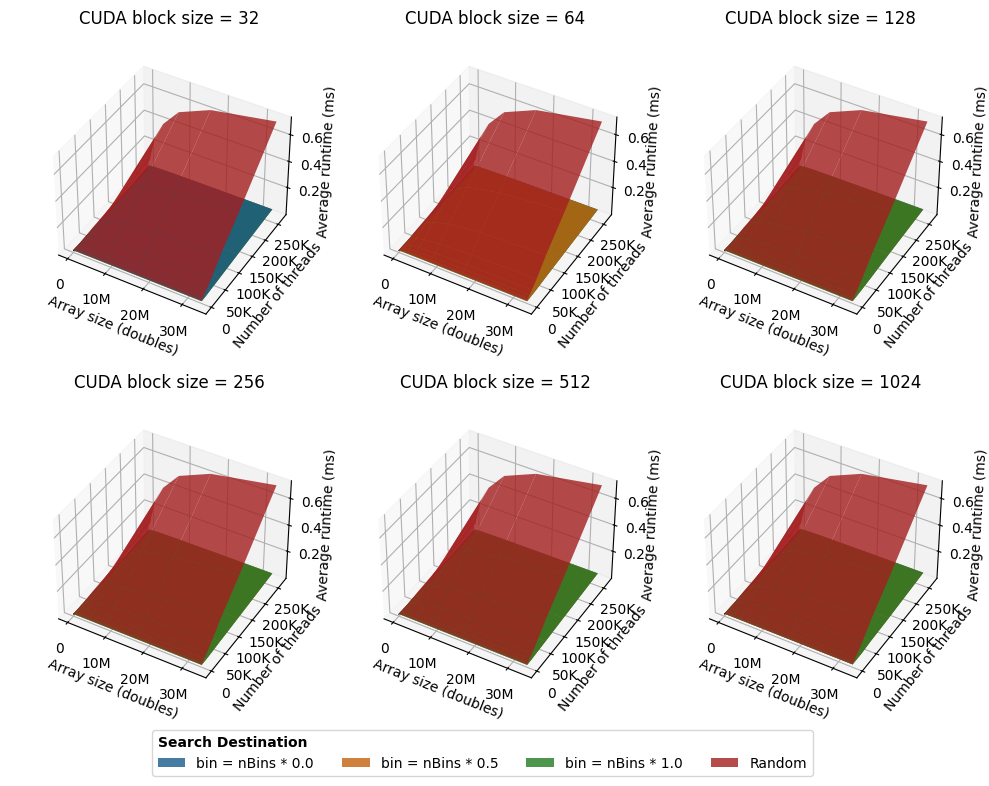

In [15]:
# figname = "../../images/gpu_binsearch_mb_3d.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 1024
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={"projection": "3d"}, figsize=(10, 10))
for bi, bs in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["blocksize"].unique()):
    ax = axs[int(bi/3), bi%3]
    for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
        ax.set_title(f"CUDA block size = {bs}")
        arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
               & (bsbm_mean["param_3"] == dest) 
               & (bsbm_mean["blocksize"] == bs)
              )
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]
        X = avg["nbins"].unique()
        Y = avg["bulksize"].unique() # bulksize
        Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                         # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                        alpha=0.8,
                        label=f"bin = nBins * {int(dest)/4.}")


    arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    X = avg["nbins"].unique()
    Y = avg["bulksize"].unique() # bulksize
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                 # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                    alpha=0.8,
                    label=f"Random",
                )

    ax.set_xlabel("Array size (doubles)")
    # ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel("Number of threads")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_zlabel(f"Average runtime ({unit})")
    # ax.set_yscale("log", base=2)
    # ax.set_zlim(3, 10)
    ax.zaxis.labelpad=-0.7 # <- change the value here
    ax.view_init(elev=40, azim=-60, roll=0)
    ax.set_box_aspect(aspect=None, zoom=0.83)

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

# plt.savefig(figname, format="pdf", bbox_inches='tight')
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show

In [16]:
binsearch_ncu = pd.read_csv("../microbenchmarks/das6/binsearch_cnsts.csv")
agg_dict = {
    'number': 'mean',
    'object': lambda col: col.mode() if col.nunique() == 1 else np.nan,
}
gbc = ["ID", "Metric Name", "Metric Unit"]
agg_dict = {k: v for i in [{col: agg for col in binsearch_ncu.select_dtypes(tp).columns.difference(gbc)} 
                      for tp, agg in agg_dict.items()] for k, v in i.items()}
gp_binsearch_ncu = binsearch_ncu.groupby(gbc).agg(agg_dict)
gp_binsearch_ncu

CC  Context  Device  \
ID Metric Name                              Metric Unit                         
0  Achieved Active Warps Per SM             warp         8.6      1.0     0.0   
   Achieved Occupancy                       %            8.6      1.0     0.0   
   Active Warps Per Scheduler               warp         8.6      1.0     0.0   
   Avg. Executed Instructions Per Scheduler inst         8.6      1.0     0.0   
   Avg. Issued Instructions Per Scheduler   inst         8.6      1.0     0.0   
...                                                      ...      ...     ...   
25 Theoretical Active Warps per SM          warp         8.6      1.0     0.0   
   Theoretical Occupancy                    %            8.6      1.0     0.0   
   Threads                                  thread       8.6      1.0     0.0   
   Warp Cycles Per Executed Instruction     cycle        8.6      1.0     0.0   
   Warp Cycles Per Issued Instruction       cycle        8.6      1.0     0.0   

                                                         Estimated Speedup  \
ID Metric Name                              Metric Unit                      
0  Achieved Active Warps Per SM             warp                       NaN   
   Achieved Occupancy                       %                          NaN   
   Active Warps Per Scheduler               warp                       NaN   
   Avg. Executed Instructions Per Scheduler inst                       NaN   
   Avg. Issued Instructions Per Scheduler   inst                       NaN   
...                                                                    ...   
25 Theoretical Active Warps per SM          warp                       NaN   
   Theoretical Occupancy                    %                          NaN   
   Threads                                  thread                     NaN   
   Warp Cycles Per Executed Instruction     cycle                      NaN   
   Warp Cycles Per Issued Instruction       cycle                      NaN   

                                                         Process ID  Stream  \
ID Metric Name                              Metric Unit                       
0  Achieved Active Warps Per SM             warp           233740.0     7.0   
   Achieved Occupancy                       %              233740.0     7.0   
   Active Warps Per Scheduler               warp           233740.0     7.0   
   Avg. Executed Instructions Per Scheduler inst           233740.0     7.0   
   Avg. Issued Instructions Per Scheduler   inst           233740.0     7.0   
...                                                             ...     ...   
25 Theoretical Active Warps per SM          warp           233740.0     7.0   
   Theoretical Occupancy                    %              233740.0     7.0   
   Threads                                  thread         233740.0     7.0   
   Warp Cycles Per Executed Instruction     cycle          233740.0     7.0   
   Warp Cycles Per Issued Instruction       cycle          233740.0     7.0   

                                                          Block Size  \
ID Metric Name                              Metric Unit                
0  Achieved Active Warps Per SM             warp         (256, 1, 1)   
   Achieved Occupancy                       %            (256, 1, 1)   
   Active Warps Per Scheduler               warp         (256, 1, 1)   
   Avg. Executed Instructions Per Scheduler inst         (256, 1, 1)   
   Avg. Issued Instructions Per Scheduler   inst         (256, 1, 1)   
...                                                              ...   
25 Theoretical Active Warps per SM          warp         (256, 1, 1)   
   Theoretical Occupancy                    %            (256, 1, 1)   
   Threads                                  thread       (256, 1, 1)   
   Warp Cycles Per Executed Instruction     cycle        (256, 1, 1)   
   Warp Cycles Per Issued Instruction       cycle        (256, 1, 1)   

                        

In [17]:
gp_binsearch_ncu.loc[:, "Threads", :, :]

,,CC,Context,Device,Estimated Speedup,Process ID,Stream,Block Size,Estimated Speedup Type,Grid Size,Host Name,Kernel Name,Metric Value,Process Name,Rule Description,Rule Name,Rule Type,Section Name
ID,Metric Unit,,,,,,,,,,,,,,,,,
0,thread,8.6,1.0,0.0,NaN,233740.0,7.0,"(256, 1, 1)",NaN,"(1, 1, 1)",127.0.0.1,"void BinarySearchGPU<double>(unsigned long, co...",256,investigational_benchmarks,NaN,NaN,NaN,Launch Statistics
1,thread,8.6,1.0,0.0,NaN,233740.0,7.0,"(256, 1, 1)",NaN,"(1, 1, 1)",127.0.0.1,"void BinarySearchGPU<double>(unsigned long, co...",256,investigational_benchmarks,NaN,NaN,NaN,Launch Statistics
2,thread,8.6,1.0,0.0,NaN,233740.0,7.0,"(256, 1, 1)",NaN,"(1, 1, 1)",127.0.0.1,"void BinarySearchGPU<double>(unsigned long, co...",256,investigational_benchmarks,NaN,NaN,NaN,Launch Statistics
3,thread,8.6,1.0,0.0,NaN,233740.0,7.0,"(256, 1, 1)",NaN,"(1, 1, 1)",127.0.0.1,"void BinarySearchGPU<double>(unsigned long, co...",256,investigational_benchmarks,NaN,NaN,NaN,Launch Statistics
4,thread,8.6,1.0,0.0,NaN,233740.0,7.0,"(256, 1, 1)",NaN,"(1, 1, 1)",127.0.0.1,"void BinarySearchGPU<double>(unsigned long, co...",256,investigational_benchmarks,NaN,NaN,NaN,Launch Statistics
5,thread,8.6,1.0,0.0,NaN,233740.0,7.0,"(256, 1, 1)",NaN,"(1, 1, 1)",127.0.0.1,"void BinarySearchGPU<double>(unsigned long, co...",256,investigational_benchmarks,NaN,NaN,NaN,Launch Statistics
6,thread,8.6,1.0,0.0,NaN,233740.0,7.0,"(256, 1, 1)",NaN,"(1, 1, 1)",127.0.0.1,"void BinarySearchGPU<double>(unsigned long, co...",256,investigational_benchmarks,NaN,NaN,NaN,Launch Statistics
7,thread,8.6,1.0,0.0,NaN,233740.0,7.0,"(256, 1, 1)",NaN,"(1, 1, 1)",127.0.0.1,"void BinarySearchGPU<double>(unsigned long, co...",256,investigational_benchmarks,NaN,NaN,NaN,Launch Statistics
8,thread,8.6,1.0,0.0,NaN,233740.0,7.0,"(256, 1, 1)",NaN,"(1, 1, 1)",127.0.0.1,"void BinarySearchGPU<double>(unsigned long, co...",256,investigational_benchmarks,NaN,NaN,NaN,Launch Statistics


solution: 0.000000 x + 0.000000 y + -0.005969 = z
errors: 
 [1.22955378] 3 [1.44971919e+08 1.52426161e+06 1.61065800e+01]


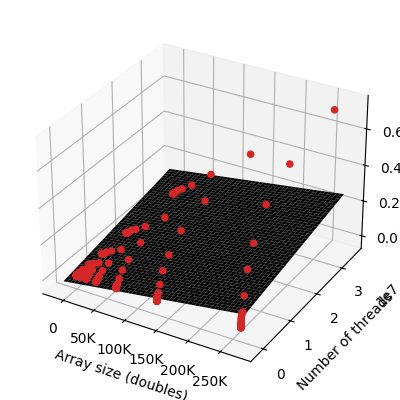

In [18]:
%matplotlib widget
# Trying to fit a plane
# figname = "../../images/gpu_binsearch_mb_3d_256blocksize.pdf"
selected_blocksize = 256
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]

def binsearch_2d(X, p0, p1, p2):
    bulksize, nbins = X
    return (p0 * bulksize) + (p1 * nbins) + p2
# binsearch_2d = np.vectorize(binsearch_2d)

fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"}, figsize=(4, 4))
bs = selected_blocksize
ax = axs
arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
X = avg["bulksize"].values # bulksize
Y = avg["nbins"].values
Z = avg["real_time"].values * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
ax.scatter(X, Y, Z,
                alpha=1, color=colors[3],
                label=f"Random",
            )
## Do fu
tmp_A = []
tmp_b = []
for i in range(len(X)):
    tmp_A.append([X[i], Y[i], 1])
    tmp_b.append(Z[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit, residual, rnk, s = scipy.linalg.lstsq(A, b)
print("solution: %f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
print("errors: \n", residual, rnk, s)

# plot fit
xlim = ax.get_xlim()
ylim = ax.get_ylim()
XX,YY = np.meshgrid(np.linspace(xlim[0], xlim[1]),
                    np.linspace(ylim[0], ylim[1]))
ZZ = np.zeros(XX.shape)
for r in range(XX.shape[0]):
    for c in range(XX.shape[1]):
        ZZ[r,c] = fit[0] * XX[r,c] + fit[1] * YY[r,c] + fit[2]
ax.plot_surface(XX,YY,ZZ, color='k')

## Axes
ax.set_xlabel("Array size (doubles)")
# ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

ax.set_ylabel("Number of threads")
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

ax.set_zlabel(f"Total runtime ({unit})")
# ax.set_yscale("log", base=2)
# ax.set_zlim(3, 10)
ax.zaxis.labelpad=-0.7 # <- change the value here

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

# plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
#            loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

<function matplotlib.pyplot.show(block=None)>

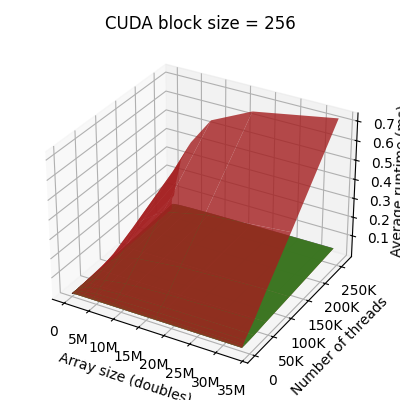

In [19]:
%matplotlib widget
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 256
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"}, figsize=(4, 4))
bs = selected_blocksize
ax = axs
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    ax.set_title(f"CUDA block size = {bs}")
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["blocksize"] == bs)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    X = avg["nbins"].unique()
    Y = avg["bulksize"].unique() # bulksize
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                     # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                    alpha=0.8,
                    label=f"bin = nBins * {int(dest)/4.}")


arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
X = avg["nbins"].unique()
Y = avg["bulksize"].unique() # bulksize
Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
             # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                alpha=0.8,
                label=f"Random",
            )

ax.set_xlabel("Array size (doubles)")
# ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
ax.set_ylabel("Number of threads")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
ax.set_zlabel(f"Average runtime ({unit})")
# ax.set_yscale("log", base=2)
# ax.set_zlim(3, 10)
ax.zaxis.labelpad=-0.7 # <- change the value here

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

# plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
#            loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show

In [20]:
%matplotlib inline

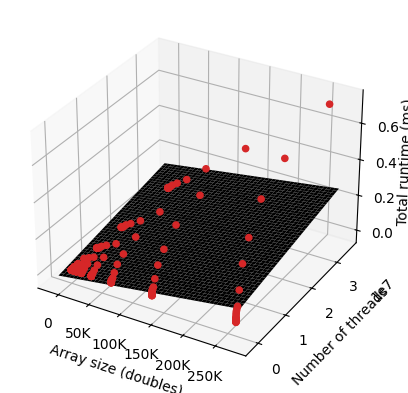

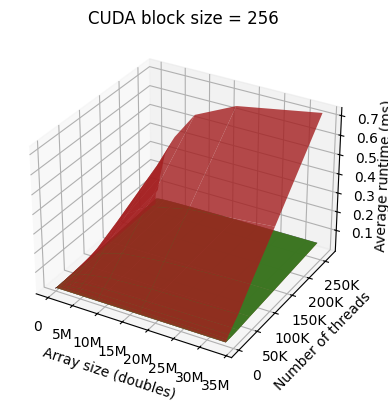

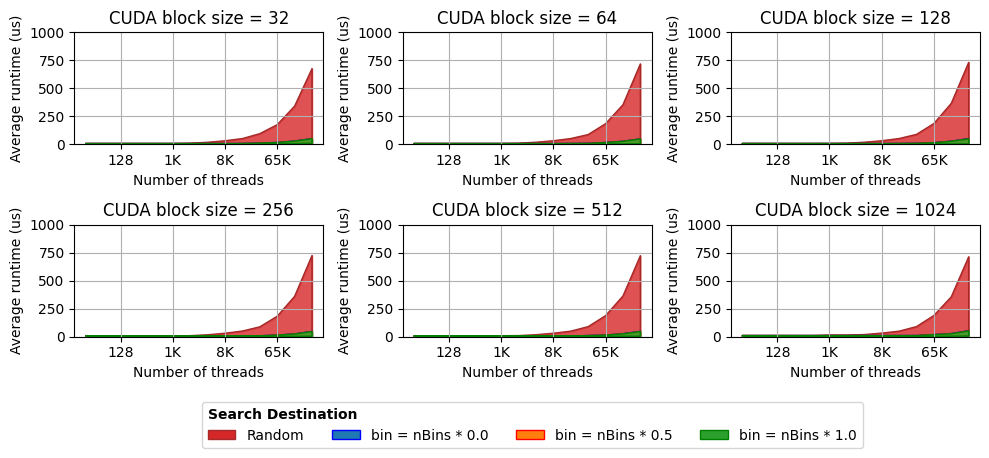

In [21]:
save = False; figname = "../../images/das6/gpu_binsearch_mb_variance.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 1024
selected_val = 0
unit = "us"
rep  = bsbm_mean["repetitions"].values[0]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))
for bi, bs in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["blocksize"].unique()):
    ax = axs[int(bi/3), bi%3]
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
           & (bsbm_mean["blocksize"] == bs))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    
    xname = "bulksize"
    X = sorted(avg[xname].unique())
    ymax = []; ymin = []
    norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    for bki, bks in enumerate(X):
        ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
        ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
        
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    fill_between_edges(ax, X, ymin, ymax, colors[3], ecolors[3], label=f"Random")
    
    for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
        ax.set_title(f"CUDA block size = {bs}")
        arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
               & (bsbm_mean["param_3"] == dest) 
               & (bsbm_mean["blocksize"] == bs)
              )
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]

        X = sorted(avg[xname].unique())
        ymax = []; ymin = []
        norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        for bki, bks in enumerate(X):
            ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
            ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
            
        Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        fill_between_edges(ax, X, ymin, ymax, colors[di], ecolors[di], label=f"bin = nBins * {int(dest)/4.}")

    ax.set_xlabel(f'{"Array size (doubles)" if xname == "nbins" else "Number of threads"}')
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel(f"Average runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 1000)




hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

fig.tight_layout()
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.2, -.15), ncols=4)
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

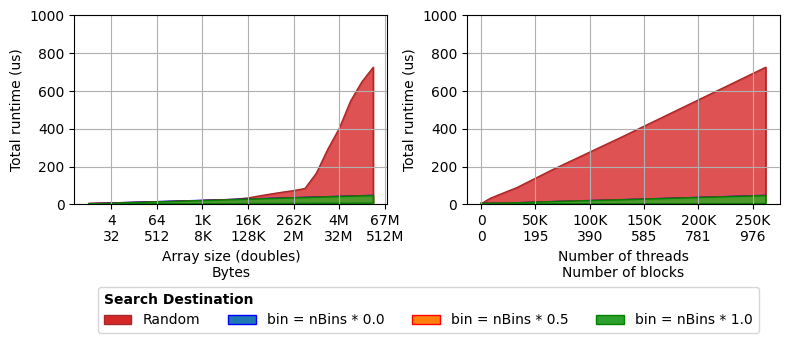

In [22]:
save = False; figname = f"../../images/das6/gpu_binsearch_mb_variance_{int(selected_blocksize)}blocksize_surface.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
for xi, xname in enumerate(["nbins" , "bulksize"]):
    ax = axs[xi]
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]

    X = avg[xname].unique()
    ymax = []; ymin = []
    norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    for bki, bks in enumerate(X):
        ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
        ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
        
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    fill_between_edges(ax, X, ymin, ymax, colors[3], ecolors[3], label=f"Random")
    
    for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
        arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
               & (bsbm_mean["param_3"] == dest) 
               & (bsbm_mean["blocksize"] == selected_blocksize)
              )
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]

        X = avg[xname].unique()
        ymax = []; ymin = []
        norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        for bki, bks in enumerate(X):
            ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
            ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
            
        Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        fill_between_edges(ax, X, ymin, ymax, colors[di], ecolors[di], label=f"bin = nBins * {int(dest)/4.}")

    if xname == "nbins":
        ax.set_xlabel("Array size (doubles)\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
    else:
        ax.set_xlabel("Number of threads\nNumber of blocks")
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
        # ax.plot(avg[xname].unique(), sorted(avg[xname].unique()))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 1000)


hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

fig.tight_layout()
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.12, -.15), ncols=4)
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

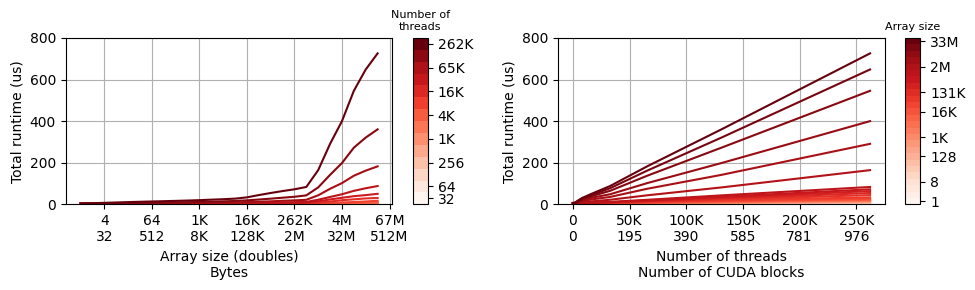

In [145]:
save = True; figname = f"../../images/das6/gpu_binsearch_mb_variance_{int(selected_blocksize)}blocksize_lines.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
xnms = ["nbins" , "bulksize"]
for xi, xname in enumerate(xnms):
    ax = axs[xi]
    X = bsbm_mean[xnms[(xi + 1) % 2]].unique()
    
    cmin = 0.15
    cmap = plt.get_cmap('Reds', len(X))
    redcolors= plt.cycler("color", plt.cm.Reds(np.linspace(cmin,1,len(X)))).by_key()['color'] 
    for bki, bks in enumerate(range(0, len(X), 1)):
        arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
               & (bsbm_mean["blocksize"] == selected_blocksize)
               & (bsbm_mean[xnms[(xi + 1) % 2]] == X[bki])
              )
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]

        norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        ax.plot(bsbm_mean[xname].unique(), avg["real_time"] * norm, color=redcolors[bki])
        
        # ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
        # ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
        
    # Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    # fill_between_edges(ax, X, ymin, ymax, colors[3], ecolors[3], label=f"Random")
    
    if xname == "nbins":
        ax.set_xlabel("Array size (doubles)\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
    else:
        ax.set_xlabel("Number of threads\nNumber of CUDA blocks")
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
        # ax.plot(avg[xname].unique(), sorted(avg[xname].unique()))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 800)

    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])        
    start_of_clb_cell = np.cumsum(np.repeat(1/len(X), len(X)))
    middle_of_clb_cell = start_of_clb_cell - (1/(2*len(X)))
    div = min(len(X), 8)
    idx = np.linspace(0, len(start_of_clb_cell)-1, div, dtype=int)

    clb = plt.colorbar(sm, 
                 ticks=middle_of_clb_cell[idx],
                 format=ticker.FuncFormatter(lambda x, pos, X=X, idx=idx: f"{human_readable(X[idx[pos]])}"),
                 ax=ax, aspect=11
                )
    clb.ax.set_title('Number of\nthreads' if xname == "nbins" else "Array size", fontsize=8)
    
hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

fig.tight_layout()
# fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
#            loc='lower left', bbox_to_anchor=(.12, -.15), ncols=4)

# from mpl_toolkits.axes_grid1 import make_axes_locatable

if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

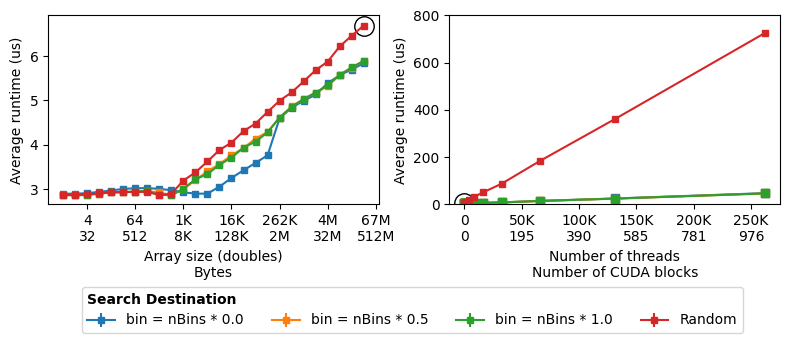

In [24]:
save = False; figname = "../../images/das6/gpu_binsearch_mb.pdf"

selected_nbins = 33554432
# selected_nbins = 1
# selected_bulksize = 32768*8
selected_bulksize = 32
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = bsbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["bulksize"] == selected_bulksize) 
           & (bsbm_mean["blocksize"] == selected_blocksize)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["nbins"], 
                 avg["real_time"]  * norm,
                 yerr=std["real_time"] *norm, 
                  label=f"bin = nBins * {int(dest)/4.}", **bm_style)

selected_func = "BinarySearchGPURandom"
arg = ((bsbm_mean["func_name"] == selected_func) 
       & (bsbm_mean["bulksize"] == selected_bulksize) 
       & (bsbm_mean["blocksize"] == selected_blocksize)
      )
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["nbins"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] * norm, label=f"Random",
             **bm_style
            )


plt.plot(selected_nbins, 
         avg.loc[avg["nbins"] == selected_nbins]["real_time"] * norm,
         'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([0, 800])
plt.grid()

# plt.axvline(x=a4000_l2_size/8, c="k")
# plt.text(a4000_l2_size/8*1.2, 450, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

#############

ax = plt.subplot(122)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant")
           &  (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["nbins"] == selected_nbins)  
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm, 
                 marker="s",
                 # label=f"v = {int(dest)/4.}"
                )
arg = ((bsbm_mean["func_name"] == selected_func)
       & (bsbm_mean["nbins"] == selected_nbins)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
             yerr=std["real_time"] * norm, **bm_style, 
             # label=f"v = {int(dest)/4.}"
            )

plt.plot(selected_bulksize, 
            avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm ,
            'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Number of threads\nNumber of CUDA blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
# secax = ax.secondary_xaxis('bottom')
# secax.set_xlabel('period [s]')

plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
plt.ylim([0, 800])

plt.grid()
plt.tight_layout()
fig.legend(title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.1, -0.15), ncols=4)
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

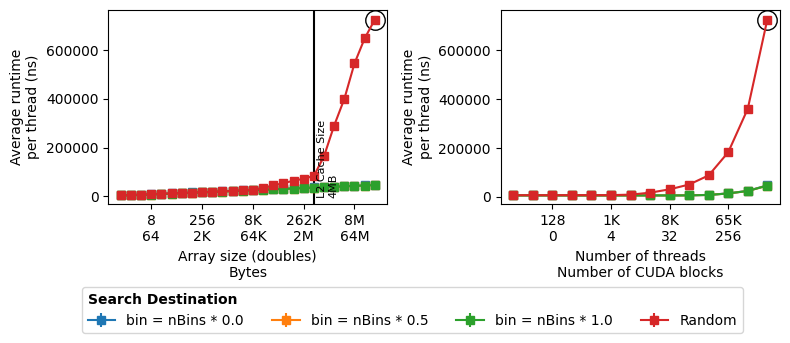

In [25]:
average = False; save = True; figname = f"../../images/das6/gpu_binsearch_mb{('_avg' if average else '')}.pdf"
selected_size = 33554432
selected_bulksize = 32768*8
selected_blocksize = 256
selected_val = 0
unit = "ns"
rep  = bsbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["bulksize"] == selected_bulksize) 
           & (bsbm_mean["blocksize"] == selected_blocksize)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["nbins"], 
                 avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm,
                 marker="s",label=f"bin = nBins * {int(dest)/4.}")

selected_func = "BinarySearchGPURandom"
arg = ((bsbm_mean["func_name"] == selected_func) 
       & (bsbm_mean["bulksize"] == selected_bulksize) 
       & (bsbm_mean["blocksize"] == selected_blocksize)
      )
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["nbins"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] * norm,
             marker="s", label=f"Random"
            )

# selected point
plt.plot(selected_size, 
         avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
         'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"Average runtime\nper thread ({unit})")
# plt.yscale("symlog")
# plt.ylim([0, 800])
plt.grid()
plt.axvline(x=a4000_l2_size/8, c="k")
plt.text(a4000_l2_size/8*1.2, 1.5, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

#############

ax = plt.subplot(122)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant")
           &  (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["nbins"] == selected_size)  
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
    plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm,
                 marker="s",
                 # label=f"v = {int(dest)/4.}"
                )
arg = ((bsbm_mean["func_name"] == selected_func)
       & (bsbm_mean["nbins"] == selected_size)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
             yerr=std["real_time"] * norm,
             # label=f"v = {int(dest)/4.}"
                 marker="s",
             
            )

# selected point
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
plt.plot(selected_bulksize, 
            avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm,
            **sl_style)
plt.xlabel("Number of threads\nNumber of CUDA blocks")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
# secax = ax.secondary_xaxis('bottom')
# secax.set_xlabel('period [s]')

plt.ylabel(f"Average runtime\nper thread ({unit})")
# plt.yscale("symlog")
# plt.ylim([0, 800])
# ax.set_ylim([0, 0.02])
plt.grid()

plt.tight_layout()
fig.legend(title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.1, -0.15), ncols=4)
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Calibration

[1.56162451e-01 5.05375605e+03]


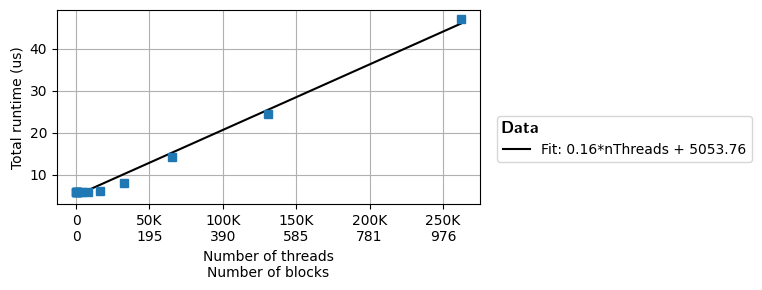

In [26]:
average = False; save=False; figname = f"../../images/gpu_addbincontent_calib{('_avg' if average else '')}.pdf"

###########
def T_bsearch(nthreads, a,b):
    # return a * np.exp(-b * nthreads) + c
    return a * nthreads + b
    
selected_nbins = 33554432
selected_bulksize = 32768*8
selected_blocksize = 256
unit = "us"
rep  = bsbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

#####
dest = '0'
arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant")
       & (bsbm_mean["param_3"] == dest) 
       & (bsbm_mean["nbins"] == selected_nbins)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
ax.errorbar(avg["bulksize"], avg["real_time"]  * norm,
             yerr=std["real_time"] * norm, marker="s", ls="",
             # label=f"v = {int(dest)/4.}"
            )

norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], "ns") / rep 
T_bsearch_popt, pcov = scipy.optimize.curve_fit(T_bsearch,  avg["bulksize"], avg["real_time"]  * norm,                                      
                                                  # p0=[6784,24,0], 
                                                  # method='trf',
                                                  maxfev=100000)
x = np.linspace(0, max(avg["bulksize"]))
ax.plot(x, T_bsearch(x, *T_bsearch_popt) * unit_to_unit_factor("ns", unit), 'k-', 
         label="Fit: {}*nThreads + {}".format(*[round(r, 2) for r in T_bsearch_popt]))
print(T_bsearch_popt)

#####
# dest = ''
# arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
#        # & (bsbm_mean["param_3"] == dest) 
#        & (bsbm_mean["nbins"] == selected_nbins)  
#        & (bsbm_mean["blocksize"] == selected_blocksize))
# avg = bsbm_mean.loc[arg]
# std = bsbm_std.loc[arg]
# ax.errorbar(avg["bulksize"], avg["real_time"]  * norm,
#              yerr=std["real_time"] * norm, marker="s", ls="",
#              # label=f"v = {int(dest)/4.}"
#             )

# norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], "ns") / rep 
# T_bsearch_popt2, pcov = scipy.optimize.curve_fit(T_bsearch,  avg["bulksize"], avg["real_time"]  * norm,                                      
#                                                   # p0=[6784,24,0], 
#                                                   # method='trf',
#                                                   maxfev=100000)
# print(T_bsearch_popt2)
# plt.plot(x, T_bsearch(x, *T_bsearch_popt2) * unit_to_unit_factor("ns", unit), 'k-', 
#          label="Fit: {}*nThreads + {}".format(*[round(r, 2) for r in T_bsearch_popt2]))
# ####


plt.xlabel("Number of threads\nNumber of blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([0, 500])

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Data}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")

fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.42), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

In [27]:
norm = unit_to_unit_factor("us", "ns")
T_a4000_globmem = 700 * norm
T_a4000_l2 = 100 * norm
T_a4000_l1 = 0.1 * norm

In [28]:
def T_gpu_binsearch(distr, nbins, bulksize):
    subsize = np.array(get_subsize(distr, nbins))
    try:
        T = np.repeat(T_a4000_globmem, len(subsize)).astype(np.float64) 
        T[subsize < a4000_l2_size/8] = T_a4000_l2  * (bulksize/262144)
        T[subsize < 16e3] = T_a4000_l1  * (bulksize/262144)
        return T * (bulksize/262144)
    except:
        if subsize < 16e3: return T_a4000_l1  * (bulksize/262144)
        elif subsize < a4000_l2_size/8: return T_a4000_l2  * (bulksize/262144)
        else: return T_a4000_globmem * (bulksize/262144)

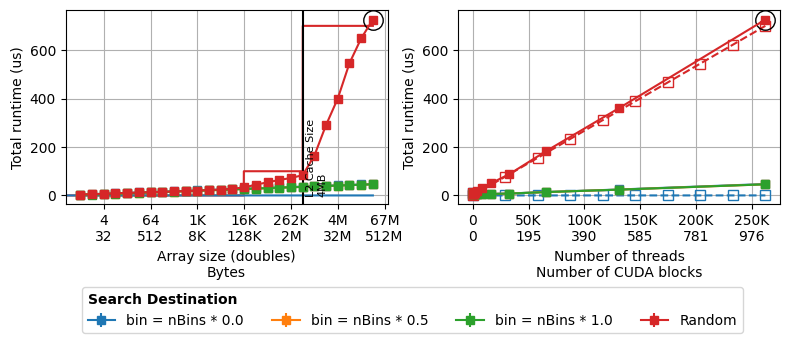

In [29]:
average = False; save=True; figname = f"../../images/das6/gpu_binsearch_calib{('_avg' if average else '')}.pdf"
selected_nbins = 33554432
selected_bulksize = 32768*8
# selected_bulksize = 1024
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = bsbm_mean["repetitions"].values[0]
    
fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["bulksize"] == selected_bulksize) 
           & (bsbm_mean["blocksize"] == selected_blocksize)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["nbins"], 
                 avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm,
                 marker="s",label=f"bin = nBins * {int(dest)/4.}")

selected_func = "BinarySearchGPURandom"
arg = ((bsbm_mean["func_name"] == selected_func) 
       & (bsbm_mean["bulksize"] == selected_bulksize) 
       & (bsbm_mean["blocksize"] == selected_blocksize)
      )
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["nbins"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] * norm,
             marker="s", label=f"Random"
            )

# Prediction
x = np.linspace(0, int(max(avg["nbins"])), 1000000)
plt.plot(x, T_gpu_binsearch("uniform", x, selected_bulksize)  * unit_to_unit_factor("ns", unit), c=colors[3])
x = np.linspace(0, int(max(avg["nbins"])), 1000000)
plt.plot(x, T_gpu_binsearch("constant", x, selected_bulksize) * unit_to_unit_factor("ns", unit), c=colors[0])

# selected point
plt.plot(selected_size, 
         avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
         'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

# Cache sizes
plt.axvline(x=a4000_l2_size/8, c="k")
plt.text(a4000_l2_size/8*1.2, 1.5, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

#############

ax = plt.subplot(122)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant")
           &  (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["nbins"] == selected_size)  
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
    plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm,
                 marker="s",
                 # label=f"v = {int(dest)/4.}"
                )
arg = ((bsbm_mean["func_name"] == selected_func)
       & (bsbm_mean["nbins"] == selected_size)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
             yerr=std["real_time"] * norm,
             # label=f"v = {int(dest)/4.}"
                 marker="s",
             
            )

# Prediction
x = np.linspace(0, int(max(avg["bulksize"])), 10)
plt.plot(x, T_gpu_binsearch("constant", selected_nbins, x) * unit_to_unit_factor("ns", unit), 
         len(x), c=colors[0], **pred_nocolor_style)
plt.plot(x, T_gpu_binsearch("uniform", selected_nbins, x)  * unit_to_unit_factor("ns", unit), 
         len(x), c=colors[3],  **pred_nocolor_style)

# selected point
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
plt.plot(selected_bulksize, 
            avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm,
            **sl_style)
plt.xlabel("Number of threads\nNumber of CUDA blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
# secax = ax.secondary_xaxis('bottom')
# secax.set_xlabel('period [s]')

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])
# ax.set_ylim([0, 0.02])

fig.legend(title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.1, -0.15), ncols=4)
fig.tight_layout()
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

In [30]:
# https://stackoverflow.com/questions/50371428/scipy-curve-fit-raises-optimizewarning-covariance-of-the-parameters-could-not
# def g(nbins, tr1, tr2, a, b, c):
#     left_tail = np.clip(np.sign(x - start), -1, 0)
#     middle = 
#     right_tail = np.clip(np.sign(x - start), -1, 0)
#     return left_tail, middle, right_tail

# average = False; save=False; figname = f"../../images/das6/gpu_binsearch_calib{('_avg' if average else '')}.pdf"
# selected_nbins = 33554432
# selected_bulksize = 32768*8
# # selected_bulksize = 1024
# selected_blocksize = 256
# selected_val = 0
# unit = "us"
# rep  = bsbm_mean["repetitions"].values[0]
    
# fig = plt.figure(figsize=(5, 3))
# ax = plt.subplot(111)

# norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
# selected_func = "BinarySearchGPURandom"
# arg = ((bsbm_mean["func_name"] == selected_func) 
#        & (bsbm_mean["bulksize"] == selected_bulksize) 
#        & (bsbm_mean["blocksize"] == selected_blocksize)
#       )
# avg = bsbm_mean.loc[arg]
# std = bsbm_std.loc[arg]
# plt.errorbar(avg["nbins"], 
#              avg["real_time"]  * norm,
#              yerr=std["real_time"] * norm,
#              marker="s", label=f"Random"
#             )

# # Prediction
# x = np.linspace(0, int(max(avg["nbins"])), 1000000)
# plt.plot(x, T_gpu_binsearch("uniform", x, selected_bulksize)  * unit_to_unit_factor("ns", unit), c=colors[3])

# plt.xlabel("Array size (doubles)\nBytes")
# plt.xscale("log", base=2)
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))

# if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
# else: plt.ylabel(f"Total runtime ({unit})")
# # plt.yscale("symlog")
# # plt.ylim([3.5, 8])

# # Cache sizes
# plt.axvline(x=a4000_l2_size/8, c="k")
# plt.text(a4000_l2_size/8*1.2, 1.5, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

# fig.legend(title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
#            loc='lower left', bbox_to_anchor=(.1, -0.15), ncols=4)
# fig.tight_layout()
# if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
# plt.show();

## Validation

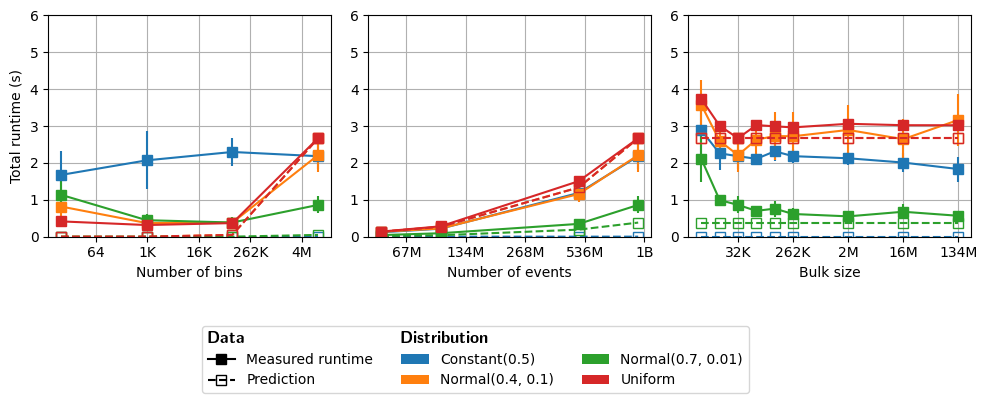

In [31]:
save=True; figname="../../images/das6/gpu_findbin_validation.pdf"

selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = True
unit="s"
norm = unit_to_unit_factor("ns", unit) 
hmax = 6

fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(131)

# Legend Labels
ax.plot(0,0, label="Measured runtime", c="k", **vd_style)
ax.plot(0,0, label="Prediction", **pred_style)

for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, 
           selected_bulksize, selected_edges, "FindBin + AddBinContent")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nbins, avg["Total Time (ns)"]* norm, 
                    yerr=std["Total Time (ns)"]* norm, 
                    # label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                   )
    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

    # Prediction
    pred = T_gpu_binsearch(distr, vd_unique_nbins, selected_bulksize) * (selected_nvals/selected_bulksize) * norm
    ax.errorbar(vd_unique_nbins, pred, 
                c=p[0].get_color(),
                marker="s", markerfacecolor="none", ls="--", markersize=7,
                # label="Prediction"
    )
    
plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

########
ax = plt.subplot(132)
for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, 
           selected_bulksize, selected_edges,  "FindBin + AddBinContent")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nvals, avg["Total Time (ns)"] * norm, 
                     yerr=std["Total Time (ns)"]* norm, 
                    # label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )

    # Prediction
    pred = T_gpu_binsearch(distr, selected_nbins, selected_bulksize) * (vd_unique_nvals/selected_bulksize) * norm
    ax.errorbar(vd_unique_nvals, pred, 
                c=p[0].get_color(),
                marker="s", markerfacecolor="none", ls="--", markersize=7,
                # label="Prediction"
    )
    
    plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])

########
ax = plt.subplot(133)
for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, selected_nvals, selected_nbins, 
           vd_unique_bulksize, selected_edges,  "FindBin + AddBinContent")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_bulksize, avg["Total Time (ns)"] * norm, 
                     yerr=std["Total Time (ns)"]* norm, 
                    # label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )

    # Prediction
    pred = T_gpu_binsearch(distr, selected_nbins, vd_unique_bulksize) * (selected_nvals/vd_unique_bulksize) * norm
    ax.errorbar(vd_unique_bulksize, pred, 
                c=p[0].get_color(),
                marker="s", markerfacecolor="none", ls="--", markersize=7,
                # label="Prediction"
    )
    
    plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylim([0, hmax])

########

ax = plt.subplot(131)
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.2, -0.35), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

fig.tight_layout()
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

# Add Bin Content

## Design

In [32]:
filename = "../microbenchmarks/das6/addbincontent_gpu.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
abcbm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(abcbm_df, "real_time", np.float64)
abcbm_df["func_name"] = abcbm_df["name"].apply(lambda s: s.split("/")[0][3:])    
del (
    abcbm_df["family_index"], abcbm_df["per_family_instance_index"],  
    abcbm_df["run_name"], abcbm_df["threads"], abcbm_df["run_type"], 
    abcbm_df["aggregate_unit"], abcbm_df["repetition_index"],  abcbm_df["error_occurred"],
    abcbm_df["error_message"]
)
abcbm_df

,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,global,nbins,numblocks,random,func_name
0,BM_HistogramGPU/8/32/32/1/1/min_time:0.000/man...,1000.0,mean,3,4052.629471,4049.260000,us,32.0,32.0,1.0,1.0,1.0,1.0,HistogramGPU
1,BM_HistogramGPU/8/32/32/1/1/min_time:0.000/man...,1000.0,median,3,4056.000233,4052.240000,us,32.0,32.0,1.0,1.0,1.0,1.0,HistogramGPU
2,BM_HistogramGPU/8/32/32/1/1/min_time:0.000/man...,0.0,stddev,3,45.150571,49.529282,us,0.0,0.0,0.0,0.0,0.0,0.0,HistogramGPU
3,BM_HistogramGPU/8/32/32/1/1/min_time:0.000/man...,0.0,cv,3,0.011141,0.012232,us,0.0,0.0,0.0,0.0,0.0,0.0,HistogramGPU
4,BM_HistogramGPU/16/32/32/1/1/min_time:0.000/ma...,1000.0,mean,3,4058.111827,4049.076667,us,32.0,32.0,1.0,2.0,1.0,1.0,HistogramGPU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,BM_HistogramGPU/134217728/262144/1024/0/0/min_...,3.0,NaN,0,0.000000,0.000000,us,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU
18716,BM_HistogramGPU/134217728/262144/1024/0/0/min_...,3.0,NaN,0,0.000000,0.000000,us,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU
18717,BM_HistogramGPU/268435456/262144/1024/0/0/min_...,3.0,NaN,0,0.000000,0.000000,us,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU
18718,BM_HistogramGPU/268435456/262144/1024/0/0/min_...,3.0,NaN,0,0.000000,0.000000,us,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU


In [33]:
unique_bulksize = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["bulksize"].unique_non_nan()
unique_blocksize = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["blocksize"].unique_non_nan()
unique_numblocks = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["numblocks"].unique_non_nan()
unique_nbins = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["nbins"].unique_non_nan()
unique_global = [True, False]
unique_random = [True, False]
unique_nbins, unique_bulksize, unique_blocksize, unique_numblocks, unique_global, unique_random

(array([1.0000000e+00, 2.0000000e+00, 4.0000000e+00, 8.0000000e+00,
        1.6000000e+01, 3.2000000e+01, 6.4000000e+01, 1.2800000e+02,
        2.5600000e+02, 5.1200000e+02, 1.0240000e+03, 2.0480000e+03,
        4.0960000e+03, 8.1920000e+03, 1.6384000e+04, 3.2768000e+04,
        6.5536000e+04, 1.3107200e+05, 2.6214400e+05, 5.2428800e+05,
        1.0485760e+06, 2.0971520e+06, 4.1943040e+06, 8.3886080e+06,
        1.6777216e+07, 3.3554432e+07]),
 array([3.20000e+01, 6.40000e+01, 2.56000e+02, 1.02400e+03, 4.09600e+03,
        1.63840e+04, 6.55360e+04, 2.62144e+05]),
 array([  32.,   64.,  128.,  256.,  512., 1024.]),
 array([1.000e+00, 2.000e+00, 8.000e+00, 3.200e+01, 1.280e+02, 5.120e+02,
        2.048e+03, 8.192e+03, 4.000e+00, 1.600e+01, 6.400e+01, 2.560e+02,
        1.024e+03, 4.096e+03]),
 [True, False],
 [True, False])

In [34]:
# n_param = len(abcbm_df["name"].values[0].split("/")) - 1
# for i in range(n_param):
#     if i == n_param - 1:
#         abcbm_df[f"param_{i}"] = abcbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0] if i+1 < len(s.split("_/")) else None)
#     else:
#         abcbm_df[f"param_{i}"] = abcbm_df["name"].apply(lambda s: s.split("/")[i+1] if i+1 < len(s.split("/")) else None)

convert_to_type(abcbm_df, "bulksize", np.int64)
convert_to_type(abcbm_df, "blocksize", np.int64)
convert_to_type(abcbm_df, "numblocks", np.int64)
convert_to_type(abcbm_df, "nbins", np.int64)
convert_to_type(abcbm_df, "random", np.bool_)
convert_to_type(abcbm_df, "global", np.bool_)
abcbm_mean = (abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"].reset_index())
abcbm_std = (abcbm_df.loc[abcbm_df["aggregate_name"] == "stddev"].reset_index())
abcbm_mean

,index,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,global,nbins,numblocks,random,func_name
0,0,BM_HistogramGPU/8/32/32/1/1/min_time:0.000/man...,1000.0,mean,3,4.052629e+03,4.049260e+03,us,32.0,32.0,True,1.0,1.0,True,HistogramGPU
1,4,BM_HistogramGPU/16/32/32/1/1/min_time:0.000/ma...,1000.0,mean,3,4.058112e+03,4.049077e+03,us,32.0,32.0,True,2.0,1.0,True,HistogramGPU
2,8,BM_HistogramGPU/32/32/32/1/1/min_time:0.000/ma...,1000.0,mean,3,3.996331e+03,3.991499e+03,us,32.0,32.0,True,4.0,1.0,True,HistogramGPU
3,12,BM_HistogramGPU/64/32/32/1/1/min_time:0.000/ma...,1000.0,mean,3,3.993259e+03,3.989512e+03,us,32.0,32.0,True,8.0,1.0,True,HistogramGPU
4,16,BM_HistogramGPU/128/32/32/1/1/min_time:0.000/m...,1000.0,mean,3,3.990144e+03,3.986826e+03,us,32.0,32.0,True,16.0,1.0,True,HistogramGPU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739,18661,BM_HistogramGPU/2048/262144/1024/0/0/min_time:...,1000.0,mean,3,1.169041e+06,1.168033e+06,us,1024.0,262144.0,False,256.0,256.0,False,HistogramGPU
3740,18665,BM_HistogramGPU/4096/262144/1024/0/0/min_time:...,1000.0,mean,3,1.165787e+06,1.164805e+06,us,1024.0,262144.0,False,512.0,256.0,False,HistogramGPU
3741,18669,BM_HistogramGPU/8192/262144/1024/0/0/min_time:...,1000.0,mean,3,1.169202e+06,1.168178e+06,us,1024.0,262144.0,False,1024.0,256.0,False,HistogramGPU
3742,18673,BM_HistogramGPU/16384/262144/1024/0/0/min_time...,1000.0,mean,3,1.171571e+06,1.170564e+06,us,1024.0,262144.0,False,2048.0,256.0,False,HistogramGPU


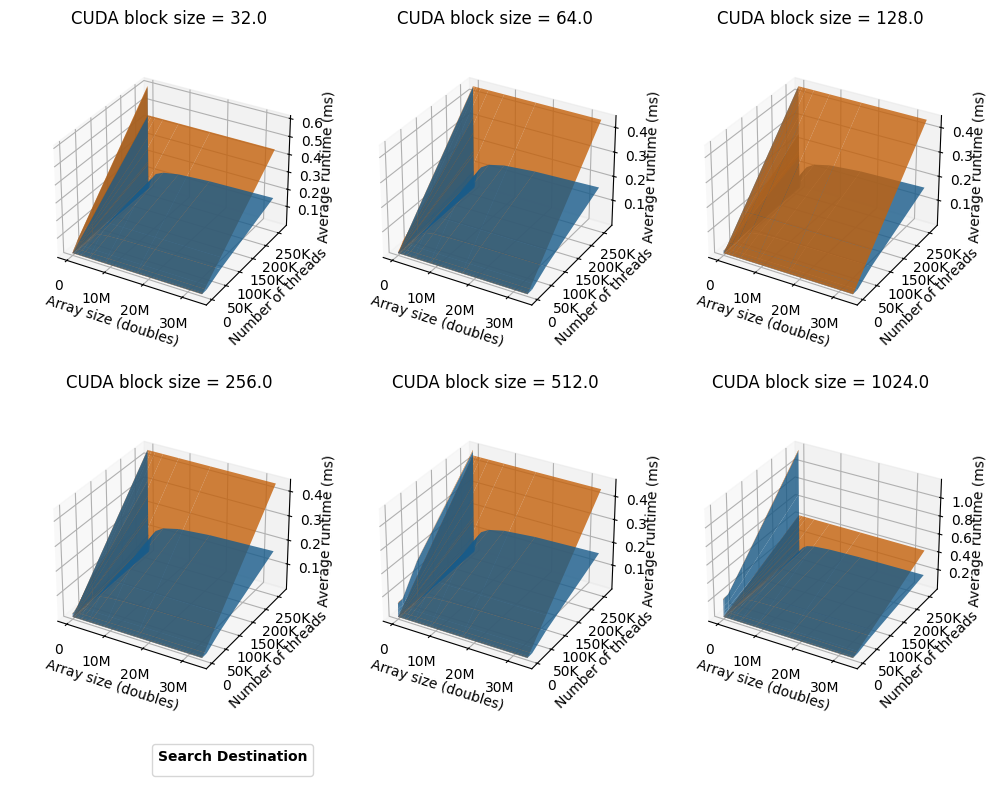

In [35]:
save = False; figname = "../../images/gpu_addbincontent_mb_3d.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 1024
selected_val = 0
unit = "ms"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={"projection": "3d"}, figsize=(10, 10))
for bi, bs in enumerate(unique_blocksize):
    ax = axs[int(bi/3), bi%3]
    # ax.grid()
    for hti, htglbl in enumerate(unique_global):
        for di, rndmdest in enumerate([True, False]):
            ax.set_title(f"CUDA block size = {bs}")
            arg = ((abcbm_mean["random"] == rndmdest) 
                   & (abcbm_mean["blocksize"] == bs)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
            X = avg["nbins"].unique()
            Y = avg["bulksize"].unique() # bulksize
            Z = avg["real_time"] * unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                             # yerr=std["real_time"] * unit_to_unit_factor(abcbm_std["time_unit"].values[0], unit) / rep, 
                            alpha=0.8,
                            color=colors[0] if rndmdest else colors[1], 
                            # hatch="xx" if htglbl else "",
                            rstride=1, cstride=1,
                            label=f"")
    

    ax.set_xlabel("Array size (doubles)")
    # ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel("Number of threads")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_zlabel(f"Average runtime ({unit})")
    # ax.set_yscale("log", base=2)
    # ax.set_zlim(3, 10)
    ax.zaxis.labelpad=-0.7 # <- change the value here
    # ax.view_init(elev=30, azim=60, roll=0)
    ax.set_box_aspect(aspect=None, zoom=0.83)

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show()

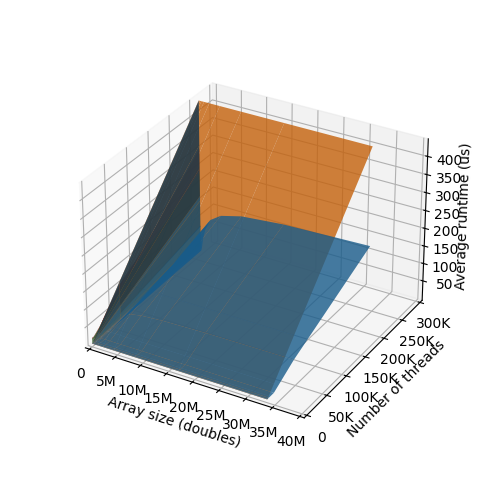

In [36]:
%matplotlib widget
figname = "../../images/gpu_addbincontent_mb_3d_256blocksize.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"}, figsize=(5, 5))
# for ai, angle in enumerate(range(0)):
    # ax = axs[int(ai/3), ai%3]
ax = axs
# ax.grid()
for hti, htglbl in enumerate([True, False]):
    for di, rndmdest in enumerate([True, False]):
        # ax.set_title(f"CUDA block size = {bs}")
        arg = ((abcbm_mean["random"] == rndmdest) 
               & (abcbm_mean["blocksize"] == selected_blocksize)
               & (abcbm_mean["global"] == htglbl)
              )
        avg = abcbm_mean.loc[arg]
        std = abcbm_std.loc[arg]
        X = avg["nbins"].unique()
        Y = avg["bulksize"].unique() # bulksize
        Z = avg["real_time"] * unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
        ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                         # yerr=std["real_time"] * unit_to_unit_factor(abcbm_std["time_unit"].values[0], unit) / rep, 
                        alpha=0.8,
                        color=colors[hti*2+di],
                        # if rndmdest else colors[1], 
                        # hatch="xx" if htglbl else "",
                        rstride=1, cstride=1,
                        label=f"")


ax.set_xlabel("Array size (doubles)")
# ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
ax.set_ylabel("Number of threads")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
ax.set_zlabel(f"Average runtime ({unit})")
# ax.set_yscale("log", base=2)
ax.zaxis.labelpad=-0.7 # <- change the value here
# ax.view_init(elev=10, azim=angle, roll=0)
ax.set_box_aspect(aspect=None, zoom=0.83)
ax.set_xlim(0, 40000000)
ax.set_ylim(0, 300000)
# ax.invert_xaxis()

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

# plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
#            loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show()


In [37]:
%matplotlib inline

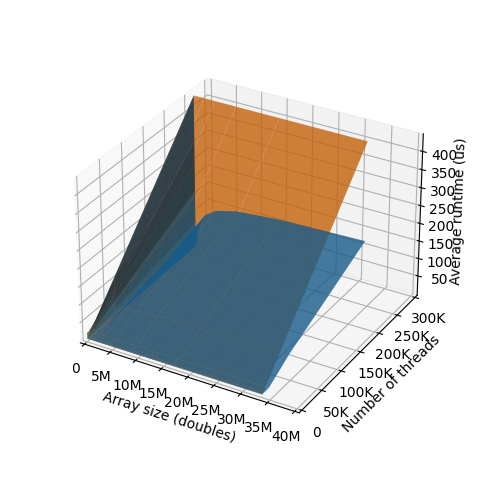

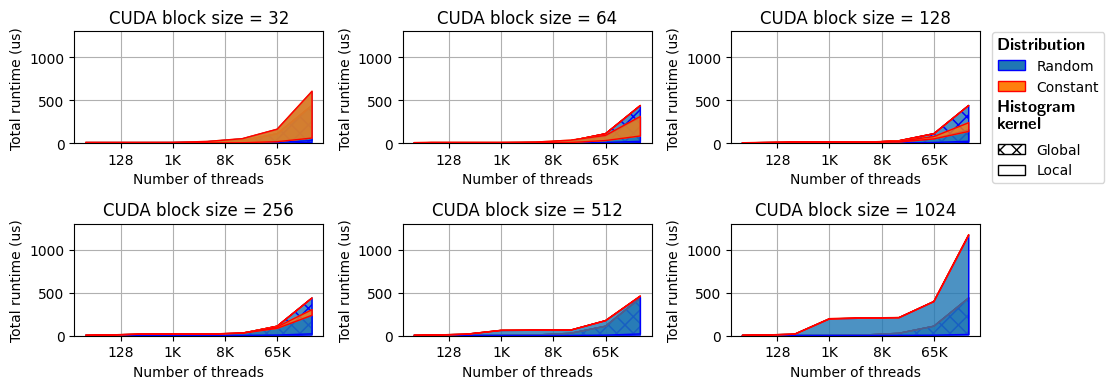

In [38]:
save = False; figname = "../../images/gpu_addbincontent_mb_variance.pdf"
selected_blocksize = 256
selected_bulksize = 32768
selected_nbins = 33554432
# selected_random = True
# selected_global = False
unit = "us"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))
for bi, bs in enumerate(unique_blocksize):
    ax = axs[int(bi/3), bi%3]
    # ax.grid()
    for hti, htglbl in enumerate(unique_global):
        for di, rndmdest in enumerate([True, False]):
            ax.set_title(f"CUDA block size = {int(bs)}")
            arg = ((abcbm_mean["blocksize"] == bs)
                   # & (abcbm_mean["bulksize"] == selected_bulksize) 
                   # & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
    
            xname = "bulksize"
            X = sorted(avg[xname].unique())
            ymax = []; ymin = []
            norm =  unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            for bki, bks in enumerate(X):
                ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
                ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
                
            Z = avg["real_time"] * unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            fill_between_edges(ax, X, ymin, ymax, 
                               facecolor=colors[0] if rndmdest else colors[1], 
                               edgecolor="b" if rndmdest else "r", 
                                label="",
                                hatch="xx" if htglbl else "", 
                                zorder=100,
                              )
            
    ax.set_xlabel(f'{"Array size (doubles)" if xname == "nbins" else "Number of threads"}')
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 1300)
    
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], edgecolor=ecolors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], edgecolor=ecolors[1], label=f"Constant"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0,  hatch="xx" , edgecolor="k", facecolor="white", label=f"Global"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor="white", edgecolor="k", label=f"Local"))

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.51), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

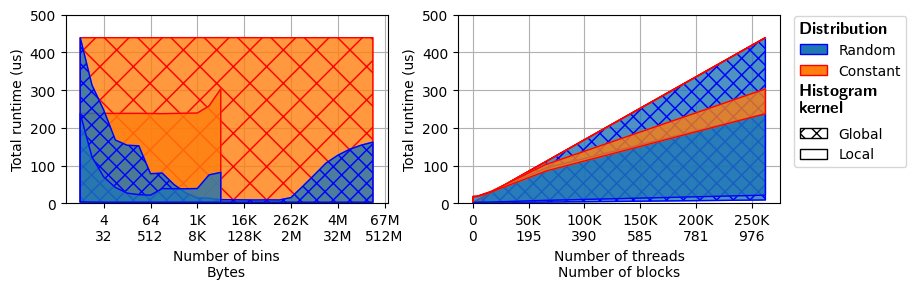

In [39]:
save = False; figname = "../../images/gpu_addbincontent_mb_variance_256blocksize.pdf"
selected_nbins = 4096
selected_bulksize = 262144
selected_blocksize = 256
# selected_random = True
# selected_global = False
unit = "us"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
for xi, xname in enumerate(["nbins"]):
    ax = axs[xi]
    # ax.grid()
    for di, rndmdest in enumerate([False, True]):
        for hti, htglbl in enumerate([True, False]):
            # ax.set_title(f"Array size (doubles) = {int(selected_nbins)}")
            arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                   # & (abcbm_mean["bulksize"] == selected_bulksize) 
                   # & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
    
            X = sorted(avg[xname].unique())
            ymax = []; ymin = []
            norm =  unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            for bki, bks in enumerate(X):
                ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
                ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)

            hatch = ""
            if htglbl:
                if rndmdest: hatch="xx"
                else: hatch="x"
            Z = avg["real_time"] * norm
            fill_between_edges(ax, X, ymin, ymax, 
                               facecolor=colors[0] if rndmdest else colors[1], 
                               edgecolor="b" if rndmdest else "r", 
                               label="",
                               hatch=hatch,
                               zorder=100,
                               # edgelinewidth=2
                                # hatch="xx" if htglbl else "", 
                              )
    if xname == "nbins":
        ax.set_xlabel(f"Number of bins\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
    else:
        ax.set_xlabel("Number of threads\nNumber of blocks")
        # ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 500)
######
for xi, xname in enumerate(["bulksize"]):
    ax = axs[1]
    for rndmdest, htglbl in ([[True, True], [False, True], [True, False], [False, False]]):
        # for hti, htglbl in enumerate([True, False]):
        # ax.set_title(f"Array size (doubles) = {int(selected_nbins)}")
        arg = ((abcbm_mean["blocksize"] == selected_blocksize)
               # & (abcbm_mean["bulksize"] == selected_bulksize) 
               # & (abcbm_mean["nbins"] == selected_nbins)
               & (abcbm_mean["random"] == rndmdest)
               & (abcbm_mean["global"] == htglbl)
              )
        avg = abcbm_mean.loc[arg]
        std = abcbm_std.loc[arg]

        X = sorted(avg[xname].unique())
        ymax = []; ymin = []
        norm =  unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
        for bki, bks in enumerate(X):
            ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
            ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)

        hatch = ""
        if htglbl:
            if rndmdest: hatch="xx"
            else: hatch="x"
        Z = avg["real_time"] * norm
        fill_between_edges(ax, X, ymin, ymax, 
                           facecolor=colors[0] if rndmdest else colors[1], 
                           edgecolor="b" if rndmdest else "r", 
                           label="",
                           hatch=hatch,
                           zorder=100,
                           # edgelinewidth=2
                            # hatch="xx" if htglbl else "", 
                          )
    if xname == "nbins":
        ax.set_xlabel(f"Number of bins\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
    else:
        ax.set_xlabel("Number of threads\nNumber of blocks")
        # ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 500)
###
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], edgecolor=ecolors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], edgecolor=ecolors[1], label=f"Constant"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0,  hatch="xx" , edgecolor="k", facecolor="white", label=f"Global"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor="white", edgecolor="k", label=f"Local"))

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.4), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

In [101]:
np.linspace(1/len(Xs), 1, len(Xs)) - (1/(2*len(Xs)))

array([0.01923077, 0.05769231, 0.09615385, 0.13461538, 0.17307692,
       0.21153846, 0.25      , 0.28846154, 0.32692308, 0.36538462,
       0.40384615, 0.44230769, 0.48076923, 0.51923077, 0.55769231,
       0.59615385, 0.63461538, 0.67307692, 0.71153846, 0.75      ,
       0.78846154, 0.82692308, 0.86538462, 0.90384615, 0.94230769,
       0.98076923])

In [117]:
idx

array([ 0,  8, 16, 25])

In [116]:
len(Xs)

26

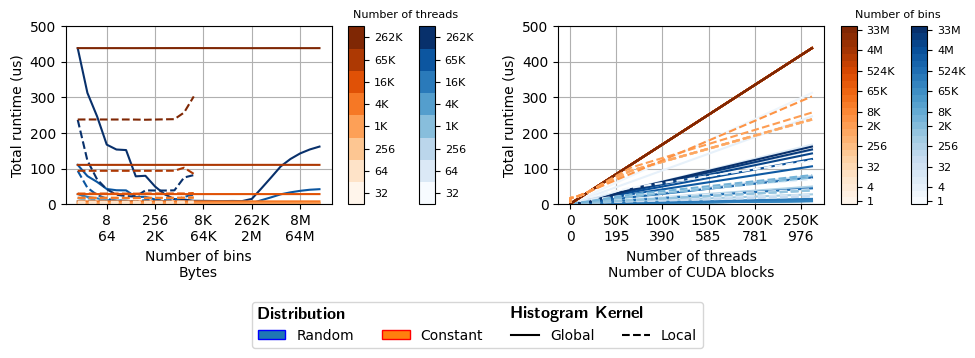

In [132]:
save = True; figname = "../../images/das6/gpu_addbincontent_mb_variance_256blocksize_lines.pdf"
selected_nbins = 4096
selected_bulksize = 262144
selected_blocksize = 256
# selected_random = True
# selected_global = False
unit = "us"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))  

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
xnms = ["nbins" , "bulksize"]
X = [sorted(abcbm_mean["bulksize"].unique()), sorted(abcbm_mean["nbins"].unique())]
for xi, xname in enumerate(xnms):
    ax = axs[xi]
    Xs = X[xi]
    for di, rndmdest in enumerate([True, False]):
        cmin = 0
        if rndmdest:
            cmap = plt.get_cmap('Blues', len(Xs))
            cmapcolors= plt.cycler("color", plt.cm.Blues(np.linspace(cmin,1,len(Xs)))).by_key()['color'] 
        else:
            cmap = plt.get_cmap('Oranges', len(Xs))
            cmapcolors= plt.cycler("color", plt.cm.Oranges(np.linspace(cmin,1,len(Xs)))).by_key()['color'] 
        
        for hti, htglbl in enumerate([True, False]):
            # if htglbl: m="s"
            # else: m="o"
            if htglbl: ls="-"
            else: ls="--"
                
            for bki, bks in enumerate(range(0, len(Xs), 1)):
                arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                       # & (abcbm_mean["bulksize"] == selected_bulksize) 
                       & (abcbm_mean[xnms[(xi + 1) % 2]] == Xs[bki])
                       & (abcbm_mean["random"] == rndmdest)
                       & (abcbm_mean["global"] == htglbl)
                      )
                avg = abcbm_mean.loc[arg]
                std = abcbm_std.loc[arg]
    
                norm =  unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
                ax.plot(avg[xname].unique(), avg["real_time"] * norm, 
                        ls=ls,
                        # marker=m, ms=5, markerfacecolor=cmapcolors[bki] if htglbl else "none",
                        color=cmapcolors[bki])

        norm = mpl.colors.Normalize(vmin=0,vmax=1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])        
        start_of_clb_cell = np.cumsum(np.repeat(1/len(Xs), len(Xs)))
        middle_of_clb_cell = start_of_clb_cell - (1/(2*len(Xs)))
        div = min(len(Xs), 10)
        idx = np.linspace(0, len(start_of_clb_cell)-1, div, dtype=int)
        clb = plt.colorbar(sm, 
                 # ticks=np.linspace(1/len(Xs), 1, len(Xs)) - (1/(2*len(Xs))),
                 ticks=middle_of_clb_cell[idx],
                 format=ticker.FuncFormatter(lambda x, pos, Xs=Xs, idx=idx: f"{human_readable(Xs[idx[pos]])}"),
                 ax=ax, aspect=11
            )

        if di == 1: clb.ax.set_title(f'{" "*28}Number of threads' 
                                     if xname == "nbins" else f'{" "*28}Number of bins', fontsize=8)
        clb.ax.tick_params(labelsize=8)
        
    if xname == "nbins":
        ax.set_xlabel(f"Number of bins\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
    else:
        ax.set_xlabel("Number of threads\nNumber of CUDA blocks")
        # ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 500)

    
######
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], edgecolor=ecolors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], edgecolor=ecolors[1], label=f"Constant"))
ax.plot(0, 0, ls="-", color="k", label=f"Global")
ax.plot(0, 0, ls="--", color="k", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(2, "")
hndls.insert(4, r"\noindent\textbf{Histogram Kernel}")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(2, "")
lbls.insert(4, "")
lbls.insert(6, "")

legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.25, -0.2), ncols=4,
                    handler_map={str: LegendTitle({'fontsize':12})})

plt.tight_layout()

if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

In [80]:
ticks

array([0.01923077, 0.05769231, 0.09615385, 0.13461538, 0.17307692,
       0.21153846, 0.25      , 0.28846154, 0.32692308, 0.36538462,
       0.40384615, 0.44230769, 0.48076923, 0.51923077, 0.55769231,
       0.59615385, 0.63461538, 0.67307692, 0.71153846, 0.75      ,
       0.78846154, 0.82692308, 0.86538462, 0.90384615, 0.94230769,
       0.98076923])

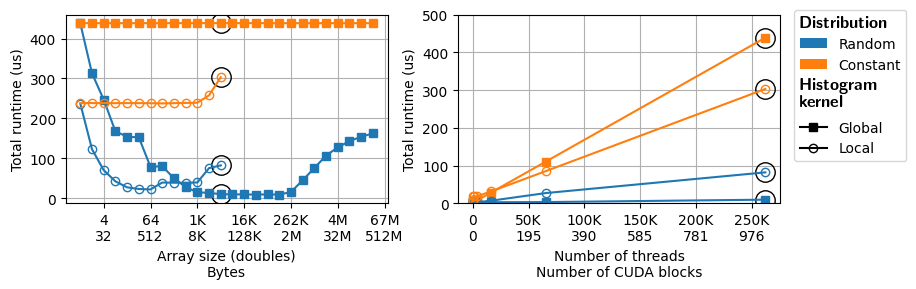

In [43]:
average = False; save = True; figname = f"../../images/das6/gpu_addbincontent_mb{('_avg' if average else '')}.pdf"

# selected_nbins = unique_nbins[-
selected_nbins = 4096
selected_bulksize = 262144
# selected_bulksize = 
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = abcbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
for hti, htglbl in enumerate([True, False]):
    for di, rndmdest in enumerate([True, False]):
        arg = ((abcbm_mean["blocksize"] == selected_blocksize)
               & (abcbm_mean["bulksize"] == selected_bulksize) 
               # & (abcbm_mean["nbins"] == selected_nbins)
               & (abcbm_mean["random"] == rndmdest)
               & (abcbm_mean["global"] == htglbl)
              )
        avg = abcbm_mean.loc[arg]
        std = abcbm_std.loc[arg]
        c = colors[0] if rndmdest else colors[1]
        ax.errorbar(avg["nbins"], 
                     avg["real_time"]  * norm,
                     yerr=std["real_time"] *norm, 
                     color=c,
                     marker="s" if htglbl else "o",
                     markerfacecolor=c if htglbl else "none"
                     # label=f"{'Global' if dest else 'Local'}", 
                     # **bm_style
                    )
        if len(avg.loc[avg["nbins"] == selected_nbins].values) > 0:
            plt.plot(selected_nbins, 
                     avg.loc[avg["nbins"] == selected_nbins]["real_time"] * norm,
                     'ok', ms=14, markerfacecolor="None",)

# plt.axvline(x=a4000_maxsmem/8, c="k")
# plt.text(a4000_maxsmem/8*1.2, 5*norm, f'Shared memory\n{human_readable(a4000_maxsmem, bytes=True)}B',
#          rotation=90, fontsize=8)
# plt.axvline(x=a4000_l2_size/8, c="k")
# plt.text(a4000_l2_size/8*1.2, 5*norm, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',
#          rotation=90, fontsize=8)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([0, 500])

#############

ax = plt.subplot(122)
for hti, htglbl in enumerate([True, False]):
    for di, rndmdest in enumerate([True, False]):
        arg = ((abcbm_mean["blocksize"] == selected_blocksize)
               # & (abcbm_mean["bulksize"] == selected_bulksize) 
               & (abcbm_mean["nbins"] == selected_nbins)
               & (abcbm_mean["random"] == rndmdest)
               & (abcbm_mean["global"] == htglbl)
              )
        avg = abcbm_mean.loc[arg]
        std = abcbm_std.loc[arg]
        
        if len(avg.values)>0:
            norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
            c = colors[0] if rndmdest else colors[1]
            ax.errorbar(avg["bulksize"], 
                         avg["real_time"]  * norm,
                         yerr=std["real_time"] *norm,
                         color=c,
                         marker="s" if htglbl else "o",
                         markerfacecolor=c if htglbl else "none"
                         # label=f"{'Global' if dest else 'Local'}", 
                         # **bm_style
                        )
            
            norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
            plt.plot(selected_bulksize, 
                     avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm,
                     'ok', ms=14, markerfacecolor="None",)
            
# plt.plot(selected_size, 
#          avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
#          'ok', ms=14, markerfacecolor="None",)
plt.xlabel("Number of threads\nNumber of CUDA blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
plt.ylim([0, 500])

ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], label=f"Constant"))
ax.plot(0, 0, color="k", marker="s", label=f"Global")
ax.plot(0, 0, color="k", marker="o", markerfacecolor="none", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.42), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Calibration

[1.66528941e+00 1.94094708e+03]
[8.71109531e-01 1.52247128e+04]


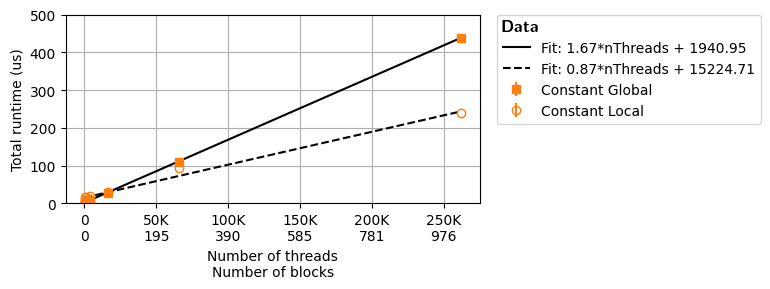

In [44]:
average = False; save = True; figname = f"../../images/das6/gpu_addbincontent_contention_calib{('_avg' if average else '')}.pdf"

###########
def T_atomic(nthreads, a,b):
    # return a * np.exp(-b * nthreads) + c
    return a * nthreads + b
    
selected_nbins = 1
selected_bulksize = 262144
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = abcbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

#####
htglbl = True
rndmdest = False
arg = ((abcbm_mean["blocksize"] == selected_blocksize)
       & (abcbm_mean["nbins"] == selected_nbins)
       & (abcbm_mean["random"] == rndmdest)
       & (abcbm_mean["global"] == htglbl))
avg = abcbm_mean.loc[arg]
std = abcbm_std.loc[arg]

x = np.linspace(0, max(avg["bulksize"]))
norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
ax.errorbar(avg["bulksize"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] *norm,
             color=colors[1], ls="",
             marker="s" if htglbl else "o",
             markerfacecolor=colors[1] if htglbl else "none",
             label=f"Constant {('Global' if htglbl else 'Local')}", 
            # **bm_style
        )


norm = (unit_to_unit_factor(abcbm_mean["time_unit"].values[0], "ns") / rep / 
        (avg["bulksize"].loc[avg["bulksize"] > 4096] if average else 1))
T_globatomic_popt, pcov = scipy.optimize.curve_fit(T_atomic,  avg["bulksize"], avg["real_time"]  * norm,
                                      # p0=[6784,24,0], 
                                      # method='trf',
                                      maxfev=100000)
print(T_globatomic_popt)
plt.plot(x, T_atomic(x, *T_globatomic_popt) * unit_to_unit_factor("ns", unit), 'k-', 
         label="Fit: {}*nThreads + {}".format(*[round(r, 2) for r in T_globatomic_popt]))

#####
htglbl = False
rndmdest = False
arg = ((abcbm_mean["blocksize"] == selected_blocksize)
       & (abcbm_mean["nbins"] == selected_nbins)
       & (abcbm_mean["random"] == rndmdest)
       & (abcbm_mean["global"] == htglbl))
avg = abcbm_mean.loc[arg]
std = abcbm_std.loc[arg]
norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
ax.errorbar(avg["bulksize"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] *norm,
             color=colors[1], ls="",
             marker="s" if htglbl else "o",
             markerfacecolor=colors[1] if htglbl else "none",
             label=f"Constant {('Global' if htglbl else 'Local')}", 
             # **bm_style
        )

norm = (unit_to_unit_factor(abcbm_mean["time_unit"].values[0], "ns") / rep / 
        (avg["bulksize"].loc[avg["bulksize"] > 4096] if average else 1))
T_lclatomic_popt, pcov = scipy.optimize.curve_fit(T_atomic,  avg["bulksize"], avg["real_time"]  * norm,
                                      # p0=[6784,24,0], 
                                      # method='trf',
                                      maxfev=100000)
print(T_lclatomic_popt)
plt.plot(x, T_atomic(x, *T_lclatomic_popt) * unit_to_unit_factor("ns", unit), 'k--', 
         label="Fit: {}*nThreads + {}".format(*[round(r, 2) for r in T_lclatomic_popt]))

#######

plt.xlabel("Number of threads\nNumber of blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
plt.ylim([0, 500])

# ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], label=f"Random"))
# ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], label=f"Constant"))
# ax.plot(0, 0, color="k", marker="s", label=f"Global")
# ax.plot(0, 0, color="k", marker="o", markerfacecolor="none", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Data}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")

fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.545), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

In [45]:
T_atomic

<function __main__.T_atomic(nthreads, a, b)>

In [46]:
def T_gpu_addbincontent(global_kernel, nvals, bulksize, distr, nbins):
    global_kernel = np.array(global_kernel)
    lcl_kernel = np.invert( global_kernel)
    subsize = np.array(get_subsize(distr, nbins))
    
    try:
        T = np.zeros(len(global_kernel))
        T[global_kernel] = T_atomic(bulksize/subsize[global_kernel], *T_globatomic_popt)
        T[lcl_kernel] = T_atomic(bulksize/subsize[lcl_kernel], *T_lclatomic_popt)
    except:
        if global_kernel:
            T = T_atomic(bulksize/subsize, *T_globatomic_popt)
            
        else:
            T = T_atomic(bulksize/subsize, *T_lclatomic_popt)
            
    return T
# T_gpu_addbincontent = np.vectorize(T_gpu_addbincontent)

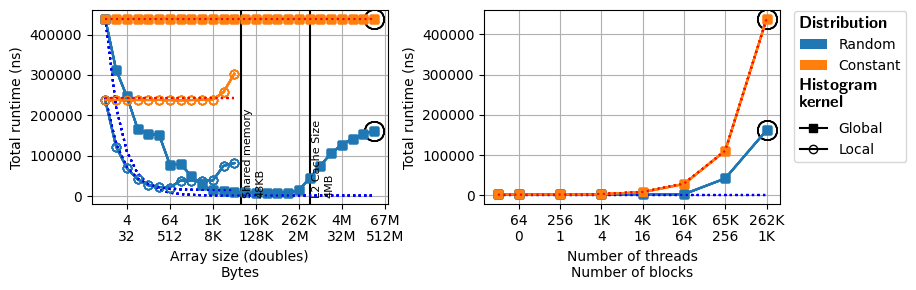

In [47]:
average = False; figname = f"../../images/das6/gpu_addbincontent_calib{('_avg' if average else '')}.pdf"

selected_nbins = unique_nbins[-1]
selected_bulksize = 262144
selected_blocksize = 256
unit = "ns"
rep  = abcbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
for bi, bs in enumerate(unique_blocksize):
    for hti, htglbl in enumerate(unique_global):
        for di, rndmdest in enumerate([True, False]):
            arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                   & (abcbm_mean["bulksize"] == selected_bulksize) 
                   # & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
            c = colors[0] if rndmdest else colors[1]
            ax.errorbar(avg["nbins"], 
                         avg["real_time"]  * norm,
                         yerr=std["real_time"] *norm, 
                         color=c,
                         marker="s" if htglbl else "o",
                         markerfacecolor=c if htglbl else "none"
                         # label=f"{'Global' if dest else 'Local'}", 
                         # **bm_style
                        )

            if len(avg.loc[avg["nbins"] == selected_nbins].values) > 0:
                ax.plot(selected_nbins, 
                         avg.loc[avg["nbins"] == selected_nbins]["real_time"] * norm,
                         'ok', ms=14, markerfacecolor="None",)

            # Prediction
            c = "b" if rndmdest else "r"
            pred = T_gpu_addbincontent(htglbl, selected_bulksize, selected_bulksize, 
                                         "uniform" if rndmdest else "constant", avg["nbins"],
                                        ) * unit_to_unit_factor("ns", unit)
            ax.errorbar(avg["nbins"], pred,
                     color=c, ls=":",
                     # marker="s" if htglbl else "o", 
                     # markerfacecolor=c if htglbl else "none",
                    )

plt.axvline(x=a4000_maxsmem/8, c="k")
plt.text(a4000_maxsmem/8*1.2, 5*norm, f'Shared memory\n{human_readable(a4000_maxsmem, bytes=True)}B',
         rotation=90, fontsize=8)
plt.axvline(x=a4000_l2_size/8, c="k")
plt.text(a4000_l2_size/8*1.2, 5*norm, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',
         rotation=90, fontsize=8)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.yscale("log", base=2)
# plt.ylim([3.5, 8])

#############

average = False
ax = plt.subplot(122)
for bi, bs in enumerate(unique_blocksize):
    for hti, htglbl in enumerate([True, False]):
        for di, rndmdest in enumerate([True, False]):
            arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                   # & (abcbm_mean["bulksize"] == selected_bulksize) 
                   & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
            
            if len(avg.values)>0:
                norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
                c = colors[0] if rndmdest else colors[1]
                ax.errorbar(avg["bulksize"], 
                             avg["real_time"]  * norm,
                             yerr=std["real_time"] *norm,
                             color=c,
                             marker="s" if htglbl else "o",
                             markerfacecolor=c if htglbl else "none"
                             # label=f"{'Global' if dest else 'Local'}", 
                             # **bm_style
                            )
                
                # Selected points
                norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
                plt.plot(selected_bulksize, 
                         avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm,
                         'ok', ms=14, markerfacecolor="None",)
    
                # Prediction
                c = "b" if rndmdest else "r"
                pred = T_gpu_addbincontent(htglbl, avg["bulksize"], avg["bulksize"],
                                             "uniform" if rndmdest else "constant", selected_nbins,
                                            )  * unit_to_unit_factor("ns", unit)
                ax.errorbar(avg["bulksize"], pred,
                         color=c, 
                         # ms=13, marker="s" if htglbl else "o", 
                         # markerfacecolor=c if htglbl else "none",
                         # markerfacecolor="k",
                         ls=":",
                        )
            
# plt.plot(x, T_atomic * unit_to_unit_factor("ns", unit), 'k-', label="Fitted Curve")

plt.xlabel("Number of threads\nNumber of blocks")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

# plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], label=f"Constant"))
ax.plot(0, 0, color="k", marker="s", label=f"Global")
ax.plot(0, 0, color="k", marker="o", markerfacecolor="none", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.42), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Validation

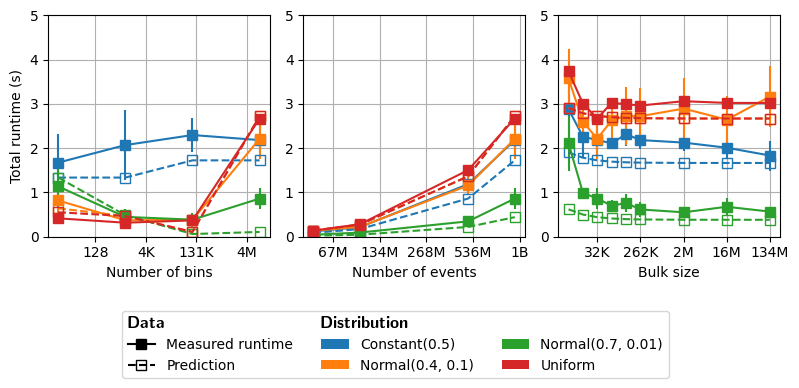

In [48]:
save = True; figname="../../images/das6/gpu_addbincontent_validation.pdf"

selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = True
unit="s"
norm = unit_to_unit_factor("ns", unit) 
hmax = 5

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(131)

# Legend Labels
ax.plot(0,0, label="Measured runtime", c="k", **vd_style)
ax.plot(0,0, label="Prediction", **pred_style)

for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, 
           selected_bulksize, selected_edges, "FindBin + AddBinContent")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nbins, avg["Total Time (ns)"]* norm, 
                    yerr=std["Total Time (ns)"]* norm, 
                    # label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                   )
    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

    # prediction
    T_abc = T_gpu_addbincontent(vd_unique_nbins*8 > a4000_maxsmem, selected_nvals, selected_bulksize,
                               distr, vd_unique_nbins)  * norm * (selected_nvals/selected_bulksize)
    T_fb = T_gpu_binsearch(distr, vd_unique_nbins, selected_bulksize)  * norm  * (selected_nvals/selected_bulksize)
    ax.errorbar(vd_unique_nbins,  T_abc + T_fb, 
                c=p[0].get_color(),  **pred_nocolor_style
               )
    
plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

##########

ax = plt.subplot(132)
for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, 
           selected_bulksize, selected_edges,  "FindBin + AddBinContent")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nvals, avg["Total Time (ns)"] * norm, 
                     yerr=std["Total Time (ns)"]* norm, 
                    # label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )
    
    # prediction
    T_abc = T_gpu_addbincontent(selected_nbins*8 > a4000_maxsmem, vd_unique_nvals, selected_bulksize,
                               distr, selected_nbins)  * norm * (vd_unique_nvals/selected_bulksize)
    T_fb = T_gpu_binsearch(distr, selected_nbins, selected_bulksize)  * norm  * (vd_unique_nvals/selected_bulksize)
    ax.errorbar(vd_unique_nvals,  T_abc + T_fb, 
                c=p[0].get_color(),  **pred_nocolor_style
               )
    
# observ = avg["tstats"].values
# print("MAE:", mae(pred, observ))
# print("R2:", r2(pred, observ) * 100)
    
    plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylim([0, hmax])

# #####################
ax = plt.subplot(133)
for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, selected_nvals, selected_nbins, 
           vd_unique_bulksize, selected_edges,  "FindBin + AddBinContent")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_bulksize, avg["Total Time (ns)"] * norm, 
                     yerr=std["Total Time (ns)"]* norm, 
                    # label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )
    
    # prediction
    T_abc = T_gpu_addbincontent(selected_nbins*8 > a4000_maxsmem, selected_nvals, vd_unique_bulksize,
                               distr, selected_nbins)  * norm  * (selected_nvals/vd_unique_bulksize)
    T_fb = T_gpu_binsearch(distr, selected_nbins, vd_unique_bulksize)  * norm  * (selected_nvals/vd_unique_bulksize)
    ax.errorbar(vd_unique_bulksize, T_abc + T_fb, 
                c=p[0].get_color(),  **pred_nocolor_style
               )

plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])
# #############

ax = plt.subplot(131)
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
fig.tight_layout()
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.3), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

# Update Stats

## Design

In [49]:
filename = "../microbenchmarks/das6/transformreduce_gpu.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
trbm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(trbm_df, "real_time", np.float64)
trbm_df["func_name"] = trbm_df["name"].apply(lambda s: s.split("/")[0][3:])    
del trbm_df["family_index"], trbm_df["per_family_instance_index"],  trbm_df["run_name"], trbm_df["threads"], trbm_df["run_type"], trbm_df["aggregate_unit"]

trbm_df.head(10)

,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,numblocks,numthreads,func_name
0,BM_TransformReduceGPU/32/32/min_time:0.001/man...,10000.0,mean,3,42383.369446,42308.476333,us,32.0,32.0,1.0,16.0,TransformReduceGPU
1,BM_TransformReduceGPU/32/32/min_time:0.001/man...,10000.0,median,3,42513.439178,42443.949000,us,32.0,32.0,1.0,16.0,TransformReduceGPU
2,BM_TransformReduceGPU/32/32/min_time:0.001/man...,0.0,stddev,3,378.127925,369.132812,us,0.0,0.0,0.0,0.0,TransformReduceGPU
3,BM_TransformReduceGPU/32/32/min_time:0.001/man...,0.0,cv,3,0.008922,0.008725,us,0.0,0.0,0.0,0.0,TransformReduceGPU
4,BM_TransformReduceGPU/64/32/min_time:0.001/man...,10000.0,mean,3,41593.503316,41525.785333,us,32.0,64.0,1.0,32.0,TransformReduceGPU
5,BM_TransformReduceGPU/64/32/min_time:0.001/man...,10000.0,median,3,41706.497192,41637.244000,us,32.0,64.0,1.0,32.0,TransformReduceGPU
6,BM_TransformReduceGPU/64/32/min_time:0.001/man...,0.0,stddev,3,355.231878,354.231052,us,0.0,0.0,0.0,0.0,TransformReduceGPU
7,BM_TransformReduceGPU/64/32/min_time:0.001/man...,0.0,cv,3,0.008541,0.008530,us,0.0,0.0,0.0,0.0,TransformReduceGPU
8,BM_TransformReduceGPU/128/32/min_time:0.001/ma...,10000.0,mean,3,41960.436503,41894.822333,us,32.0,128.0,2.0,32.0,TransformReduceGPU
9,BM_TransformReduceGPU/128/32/min_time:0.001/ma...,10000.0,median,3,42005.504608,41937.559000,us,32.0,128.0,2.0,32.0,TransformReduceGPU


In [50]:
n_param = len(trbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        trbm_df[f"param_{i}"] = trbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0] if i+1 < len(s.split("_/")) else None)
    else:
        trbm_df[f"param_{i}"] = trbm_df["name"].apply(lambda s: s.split("/")[i+1] if i+1 < len(s.split("/")) else None)

convert_to_type(trbm_df, "numthreads", np.int64)
convert_to_type(trbm_df, "numblocks", np.int64)
convert_to_type(trbm_df, "blocksize", np.int64)

trbm_mean = trbm_df.loc[trbm_df["aggregate_name"] == "mean"].reset_index()
trbm_std = trbm_df.loc[trbm_df["aggregate_name"] == "stddev"].reset_index()
# convert_to_type(
trbm_mean

,index,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,numblocks,numthreads,func_name,param_0,param_1,param_2,param_3
0,0,BM_TransformReduceGPU/32/32/min_time:0.001/man...,10000.0,mean,3,42383.369446,42308.476333,us,32,32.0,1,16,TransformReduceGPU,32,32,min_time:0.001,None
1,4,BM_TransformReduceGPU/64/32/min_time:0.001/man...,10000.0,mean,3,41593.503316,41525.785333,us,32,64.0,1,32,TransformReduceGPU,64,32,min_time:0.001,None
2,8,BM_TransformReduceGPU/128/32/min_time:0.001/ma...,10000.0,mean,3,41960.436503,41894.822333,us,32,128.0,2,32,TransformReduceGPU,128,32,min_time:0.001,None
3,12,BM_TransformReduceGPU/256/32/min_time:0.001/ma...,10000.0,mean,3,42220.544179,42128.341667,us,32,256.0,4,32,TransformReduceGPU,256,32,min_time:0.001,None
4,16,BM_TransformReduceGPU/512/32/min_time:0.001/ma...,10000.0,mean,3,41284.212748,41220.825000,us,32,512.0,8,32,TransformReduceGPU,512,32,min_time:0.001,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,316,BM_TransformReduceGPU/16384/1024/min_time:0.00...,10000.0,mean,3,43501.567841,43465.619333,us,1024,16384.0,8,1024,TransformReduceGPU,16384,1024,min_time:0.001,None
80,320,BM_TransformReduceGPU/32768/1024/min_time:0.00...,10000.0,mean,3,43509.077708,43479.155333,us,1024,32768.0,16,1024,TransformReduceGPU,32768,1024,min_time:0.001,None
81,324,BM_TransformReduceGPU/65536/1024/min_time:0.00...,10000.0,mean,3,44187.989553,44166.223667,us,1024,65536.0,32,1024,TransformReduceGPU,65536,1024,min_time:0.001,None
82,328,BM_TransformReduceGPU/131072/1024/min_time:0.0...,10000.0,mean,3,75123.372396,75101.305333,us,1024,131072.0,64,1024,TransformReduceGPU,131072,1024,min_time:0.001,None


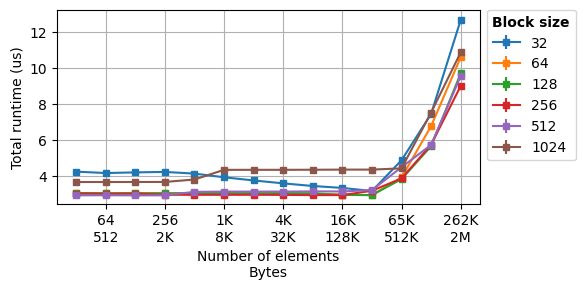

In [51]:
average = False; figname = f"../../images/gpu_updatestats_mb{('_avg' if average else '')}.pdf"

selected_bulksize = 32768*8
selected_blocksize = 256
unit = "us"
rep  = trbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(trbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

for bsi, bs in enumerate(trbm_mean["blocksize"].unique()):
    arg = (trbm_mean["blocksize"] == bs)
    avg = trbm_mean.loc[arg]
    std = trbm_std.loc[arg]
    plt.errorbar(avg["bulksize"], 
                 avg["real_time"]  * norm / (avg["bulksize"] if average else 1),
                 yerr=std["real_time"] * norm / (avg["bulksize"] if average else 1),
                 label=f"{bs}", **bm_style)

# plt.plot(selected_size, 
#          avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
#          'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Number of elements\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"{('Average' if average else 'Total')} runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

plt.tight_layout()
fig.legend(title="Block size",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='center left', bbox_to_anchor=(0.97, 0.7), ncols=1)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Calibration

[2.27171755e-02 2.82317569e+03]


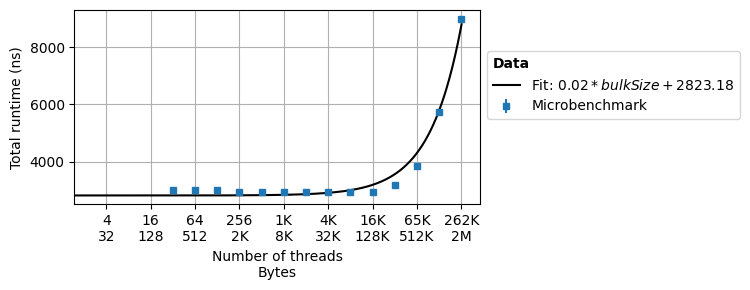

In [52]:
save = False; figname = "../../images/das6/gpu_updatestats_calib.pdf"

def T_gpu_usb(bulksize, a, b):
    # return a*np.array(bulksize) + b
    # return 1/(a*bulksize+b) + c
    return a*bulksize+b
    # return a * np.log(b * bulksize) + c
    # return a * np.exp(-b * bulksize) + c
    # return a * pow(b, bulksize) + c
    
selected_bulksize = 32768*8
selected_blocksize = 256
unit = "ns"
rep  = trbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

# microbenchmark data
arg = (trbm_mean["blocksize"] == selected_blocksize) 
avg = trbm_mean.loc[arg] 
std = trbm_std.loc[arg]
norm = unit_to_unit_factor(trbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
plt.errorbar(avg["bulksize"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] * norm,
             label=f"Microbenchmark", ls="", **bm_style)

## fit line
x = np.linspace(0, pow(2, 18)+1024, 100000)
Tusb_popt, pcov = scipy.optimize.curve_fit(T_gpu_usb, avg["bulksize"], 
                                      avg["real_time"]  * norm, 
                                      # p0=[6784,24,0], 
                                      # method='trf',
                                      maxfev=100000)
# plt.plot(x, T_gpu_usb(x, *Tusb_popt), 'k-', label=r"Fit: ${} * bulkSize^{{{}}} {}$".format(*[round(r, 2) for r in Tusb_popt]))
plt.plot(x, T_gpu_usb(x, *Tusb_popt), 'k-', label=r"Fit: ${} * bulkSize + {}$".format(*[round(r, 2) for r in Tusb_popt]))
print(Tusb_popt)


# plt.plot(x, T_gpu_usb(x, 6000, 24, 0), 'b-', label="Fitted Curve")
# plt.plot(x, T_gpu_usb(x, avg["real_time"].mean()  * norm, 24, 0), 'b-', label="Fitted Curve")

##### Calibration ######
# T_gpu_usb = np.mean(avg["real_time"].loc[avg["bulksize"] > 4096] 
#                     / avg["bulksize"].loc[avg["bulksize"] > 4096])  * norm
# plt.plot(x, np.repeat(T_gpu_usb, len(x)), 'k-', label="Calibration")

plt.xlabel("Number of threads\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.yscale("log", base=2)
# plt.ylim([0, 0.2*norm])

plt.tight_layout()
fig.legend(title="Data",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='center left', bbox_to_anchor=(0.97, 0.7), ncols=1)
if save:  plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Validation

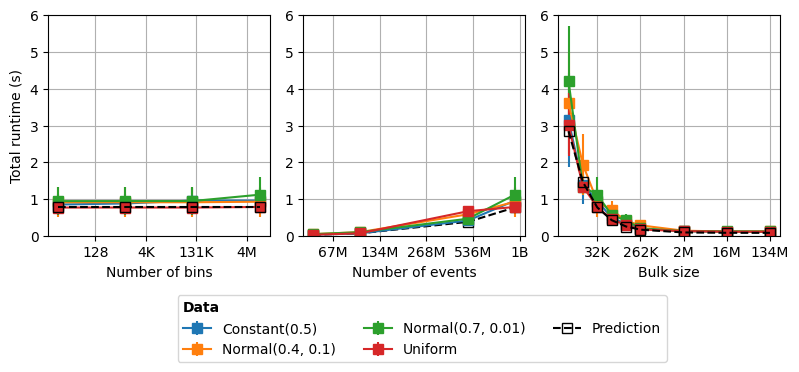

In [53]:
save = False; figname="../../images/das6/gpu_updatestats_validation.pdf"

def next_power_of_2(x):
    return 1 if x == 0 else 2**np.ceil(np.log2(x))
def transformreduce_geometry(bulksize, blocksize):
    threads =  next_power_of_2((bulksize + 1) / 2) if bulksize < blocksize * 2 else blocksize
    blocks = (bulksize + (threads * 2 - 1)) / (threads * 2)
    return int(threads), int(blocks)

selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_blocksize = 256
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = False
unit="s"
norm = unit_to_unit_factor("ns", unit) 
hmax = 6

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(131)

for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, 
           selected_bulksize, selected_edges, "UpdateStats")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nbins, avg["Total Time (ns)"]* norm, 
                    yerr=std["Total Time (ns)"]* norm, 
                    label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                   )

## Prediction
blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
pred = np.repeat((T_gpu_usb(selected_bulksize, *Tusb_popt) * 4 * (selected_nvals/selected_bulksize) # main reduction
                 + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals/selected_bulksize)) # final reduction
                 * unit_to_unit_factor("ns", "s"), len(vd_unique_nbins))
ax.errorbar(vd_unique_nbins, 
            pred,             label="Prediction", **pred_style

)
    
plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

#####################
ax = plt.subplot(132)
for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, 
           selected_bulksize, selected_edges,  "UpdateStats")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nvals, avg["Total Time (ns)"] * norm, 
                     yerr=std["Total Time (ns)"]* norm, 
                    label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )
    
## Prediction
blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
pred = ((T_gpu_usb(selected_bulksize, *Tusb_popt) * 4 * (vd_unique_nvals/selected_bulksize) # main reduction
         + T_gpu_usb(blocks, *Tusb_popt) * 4 * (vd_unique_nvals/selected_bulksize)) # final reduction
         * unit_to_unit_factor("ns", "s"))
ax.plot(vd_unique_nvals, pred, label="Prediction", **pred_style)
# observ = avg["tstats"].values
# print("MAE:", mae(pred, observ))
# print("R2:", r2(pred, observ) * 100)
    
plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])

#####################
ax = plt.subplot(133)
for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, selected_nvals, selected_nbins, 
           vd_unique_bulksize, selected_edges,  "UpdateStats")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_bulksize, avg["Total Time (ns)"] * norm, 
                    yerr=std["Total Time (ns)"]* norm, 
                    label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )

## Prediction
blocks = (vd_unique_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
pred = ((T_gpu_usb(vd_unique_bulksize, *Tusb_popt) * 4 * (selected_nvals/vd_unique_bulksize) # main reduction
         + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals/vd_unique_bulksize)) # final reduction
         * unit_to_unit_factor("ns", "s"))
ax.errorbar(vd_unique_bulksize, pred, 
            label="Prediction", **pred_style
)
# observ = avg["tstats"].values
# print("MAE:", mae(pred, observ))
# print("R2:", r2(pred, observ) * 100)

plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])

##############
fig.tight_layout()
plt.legend(title="Data", loc='lower left',  bbox_to_anchor=(-1.75, -.6), ncols=3,
           alignment="left", title_fontproperties={'weight':'bold'})

if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

# Memory Transfers

## Design

In [54]:
filename = f"{mb_input_folder}/memtransfers.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
mcpybm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(mcpybm_df, "real_time", np.float64)
mcpybm_df["func_name"] = mcpybm_df["name"].apply(lambda s: s.split("/")[0][3:])    
del (mcpybm_df["family_index"], mcpybm_df["per_family_instance_index"],  
     mcpybm_df["run_name"], mcpybm_df["threads"], mcpybm_df["run_type"], mcpybm_df["aggregate_unit"])
mcpybm_df

,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,nbytes,pinned,func_name
0,BM_DToH/1/1/min_time:0.001/manual_time_mean,300.0,mean,3,2.791221e+03,2.659160e+03,us,1.0,1.0,DToH
1,BM_DToH/1/1/min_time:0.001/manual_time_median,300.0,median,3,2.653073e+03,2.641904e+03,us,1.0,1.0,DToH
2,BM_DToH/1/1/min_time:0.001/manual_time_stddev,0.0,stddev,3,2.509788e+02,4.270174e+01,us,0.0,0.0,DToH
3,BM_DToH/1/1/min_time:0.001/manual_time_cv,0.0,cv,3,8.991721e-02,1.605836e-02,us,0.0,0.0,DToH
4,BM_DToH/2/1/min_time:0.001/manual_time_mean,300.0,mean,3,2.645566e+03,2.635863e+03,us,2.0,1.0,DToH
...,...,...,...,...,...,...,...,...,...,...
587,BM_HToD/244947350/0/min_time:0.001/manual_time_cv,0.0,cv,3,2.188629e-04,2.142984e-04,us,0.0,NaN,HToD
588,BM_HToD/268435452/0/min_time:0.001/manual_time...,300.0,mean,3,5.087605e+06,5.081666e+06,us,268435452.0,0.0,HToD
589,BM_HToD/268435452/0/min_time:0.001/manual_time...,300.0,median,3,5.086917e+06,5.081004e+06,us,268435452.0,0.0,HToD
590,BM_HToD/268435452/0/min_time:0.001/manual_time...,0.0,stddev,3,1.996648e+03,1.985671e+03,us,0.0,0.0,HToD


In [55]:
convert_to_type(mcpybm_df, "nbytes", np.int64)

mcpybm_mean = mcpybm_df.loc[mcpybm_df["aggregate_name"] == "mean"].reset_index()
mcpybm_std = mcpybm_df.loc[mcpybm_df["aggregate_name"] == "stddev"].reset_index()
# convert_to_type(
mcpybm_mean

,index,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,nbytes,pinned,func_name
0,0,BM_DToH/1/1/min_time:0.001/manual_time_mean,300.0,mean,3,2.791221e+03,2.659160e+03,us,1,1.0,DToH
1,4,BM_DToH/2/1/min_time:0.001/manual_time_mean,300.0,mean,3,2.645566e+03,2.635863e+03,us,2,1.0,DToH
2,8,BM_DToH/4/1/min_time:0.001/manual_time_mean,300.0,mean,3,2.646578e+03,2.639877e+03,us,4,1.0,DToH
3,12,BM_DToH/8/1/min_time:0.001/manual_time_mean,300.0,mean,3,2.639471e+03,2.629541e+03,us,8,1.0,DToH
4,16,BM_DToH/16/1/min_time:0.001/manual_time_mean,300.0,mean,3,2.647523e+03,2.635184e+03,us,16,1.0,DToH
...,...,...,...,...,...,...,...,...,...,...,...
143,572,BM_HToD/174483044/0/min_time:0.001/manual_time...,300.0,mean,3,3.317133e+06,3.313172e+06,us,174483044,0.0,HToD
144,576,BM_HToD/197971146/0/min_time:0.001/manual_time...,300.0,mean,3,3.762426e+06,3.757908e+06,us,197971146,0.0,HToD
145,580,BM_HToD/221459248/0/min_time:0.001/manual_time...,300.0,mean,3,4.201133e+06,4.196121e+06,us,221459248,0.0,HToD
146,584,BM_HToD/244947350/0/min_time:0.001/manual_time...,300.0,mean,3,4.643638e+06,4.638195e+06,us,244947350,0.0,HToD


NameError: name 'das6_bw_threshold' is not defined

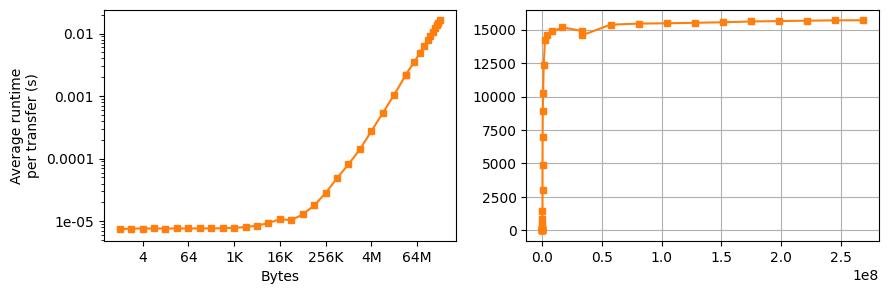

In [56]:
figname="../../images/gpu_das6_memtransfers_mb.pdf"
data_unit = "mb"
rep = mcpybm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(10, 3))

for di, dir in enumerate(["HToD"]):
    for pi, pinned in enumerate([True, False]):
        ax = plt.subplot(121)
        unit = "s"
        norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep
        
        arg = (mcpybm_mean["func_name"] == dir) & (mcpybm_mean["pinned"] == pinned)
        # plt.plot(mcpybm_mean.loc[arg]["nbytes"], mcpybm_mean.loc[arg]["nbytes"]/mcpybm_mean.loc[arg]["real_time"] * norm, "o-")
        plt.errorbar(mcpybm_mean.loc[arg]["nbytes"], mcpybm_mean.loc[arg]["real_time"] * norm, 
                     yerr=mcpybm_std.loc[arg]["real_time"] * norm, 
                     label=f"{dir} ({('pinned' if pinned else 'pageable')})",
                     # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
                     color=colors[pinned],
                     **bm_style
                    )
        plt.xlabel("Bytes")
        # plt.xlim([0, 10e6])
        # plt.ylim([0, 5000])
        plt.xscale("log", base=2)
        # plt.yscale("symlog")
        plt.yscale("log")
        plt.ylabel(f"Average runtime\nper transfer ({unit})")
        plt.grid()
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}"))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

        ##############
        ax = plt.subplot(122)
        unit = "s"
        norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep

        plt.errorbar(mcpybm_mean.loc[arg]["nbytes"], 
                      # (mcpybm_mean.loc[arg]["real_time"] * norm)/ 
                      #    (mcpybm_mean.loc[arg]["nbytes"] * unit_to_unit_factor("b", data_unit, bytes=True)), 
                     (mcpybm_mean.loc[arg]["nbytes"] * unit_to_unit_factor("b", data_unit, bytes=True)) / 
                          (mcpybm_mean.loc[arg]["real_time"] * norm), 
                     yerr=(mcpybm_std.loc[arg]["nbytes"] * unit_to_unit_factor("b", data_unit, bytes=True)) / 
                         (mcpybm_std.loc[arg]["real_time"] * norm),
                     label=f"{dir} ({('pinned' if pinned else 'pageable')})",
                     # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
                     color=colors[pinned],
                     **bm_style
                    )

        # selected point
        plt.plot(das6_bw_threshold, 
                 (das6_bw_threshold  * unit_to_unit_factor("b", data_unit, bytes=True)) / 
                 np.mean(mcpybm_mean.loc[arg & (mcpybm_mean["nbytes"] == das6_bw_threshold)]["real_time"] * norm),
                 'ok', ms=14, markerfacecolor="None",)

        plt.xlabel("Bytes")
        # plt.xlim([0, 10e6])
        # plt.ylim([0, 500])
        # plt.xscale("log", base=2)
        # plt.yscale("symlog")
        # plt.yscale("log")
        plt.grid()
        plt.ylabel(f"Bandwidth {data_unit.upper()[0]}Bytes/{unit})")
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}"))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    

plt.tight_layout()
plt.legend(title="Data",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='center left', bbox_to_anchor=(1, 0.75), ncols=1)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

In [ ]:
np.mean(mcpybm_mean.loc[arg & (mcpybm_mean["nbytes"] == das6_bw_threshold)]["real_time"])

In [ ]:
mcpybm_mean["nbytes"].unique()

## Calibration

In [ ]:
rep  = mcpybm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], "ns") / rep
arg = (mcpybm_mean["func_name"] == "HToD")
das6_alpha_pinned = np.min(mcpybm_mean.loc[arg & (mcpybm_mean["pinned"] == True)]["real_time"] * norm)
das6_alpha_paged = np.min(mcpybm_mean.loc[arg & (mcpybm_mean["pinned"] == False)]["real_time"] * norm)

# arg = (mcpybm_mean["func_name"] == "HToD") & (mcpybm_mean["nbytes"] == 1)
# das6_alpha_pinned = mcpybm_mean.loc[arg & (mcpybm_mean["pinned"] == True)]["real_time"].values[0] * norm
# das6_alpha_paged = mcpybm_mean.loc[arg & (mcpybm_mean["pinned"] == False)]["real_time"].values[0] * norm
das6_alpha_pinned, das6_alpha_paged

In [ ]:
das6_bw_threshold = 33554432
norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], "ns") / rep
arg = (mcpybm_mean["func_name"] == "HToD") & (mcpybm_mean["nbytes"] >= das6_bw_threshold)
avg_pinned = mcpybm_mean.loc[arg  & (mcpybm_mean["pinned"] == True)]
avg_paged =  mcpybm_mean.loc[arg  & (mcpybm_mean["pinned"] == False)]

das6_maxbw_htod_pinned = np.mean(avg_pinned["nbytes"] / (avg_pinned["real_time"] * norm))
das6_maxibw_htod_pinned = np.mean((avg_pinned["real_time"] * norm) / avg_pinned["nbytes"])

das6_maxbw_htod_paged = np.mean(avg_paged["nbytes"] / (avg_paged["real_time"] * norm))
das6_maxibw_htod_paged = np.mean((avg_paged["real_time"] * norm) / avg_paged["nbytes"] )

das6_bw_threshold, das6_maxbw_htod_pinned, das6_maxibw_htod_pinned, das6_maxbw_htod_paged, das6_maxibw_htod_paged

In [ ]:
# def ibw_small(bytes, a, b, c):
#     return a * (np.log(bytes) / np.log(b)) + c

# def ibw_small(bytes, a, b):
#     return a*bytes + b
    
# def ibw_small(bytes, a, b, c):
#     return a*(np.log(bytes) / np.log(b)) + c

# def ibw_small(bytes, a,b,c):
#     return a*pow(bytes, b) + c
    
def ibw_small(bytes, a, b, c, d, e, f):
    return (a*pow(bytes, 0) 
            + b *pow(bytes, 1) 
            + c *pow(bytes, 2) 
            + d *pow(bytes, 3) 
            + e *pow(bytes, 4) 
            + f *pow(bytes, 5) 
#             + g *pow(bytes, 6) 
#             + h *pow(bytes, 7) 
#             + i *pow(bytes, 8) 
        ).clip(0)

def get_poly_label(popt, r=3):
    s = []
    np = len(popt)
    for i in range(np-1, -1, -1):
        p = round(popt[i], r)
        if p > 0:
            if i == 0:
                s.append(f"{p}")
            elif i == 1:
                s.append(f"{p}x")
            else:
                s.append(f"{p}x^{i}")
                
    return " + ".join(s)

In [ ]:
ibw_smallpinned_popt

In [ ]:
get_poly_label(ibw_smallpinned_popt, 2)

In [ ]:
save = False;  figname="../../images/das6/gpu_memtransfers_calib_lambda.pdf"
    
unit = "ns"
rep  = mcpybm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep
dir = "HToD"

fig = plt.figure(figsize=(6, 3))

for di, dir in enumerate(["HToD"]):
    ax = plt.subplot(111)
    pinned = True
    arg = (mcpybm_mean["func_name"] == dir) & (mcpybm_mean["pinned"] == pinned)
    
    ylambda = (mcpybm_mean.loc[arg]["real_time"] * norm)
    xbytes = mcpybm_mean.loc[arg]["nbytes"]
    # print(mcpybm_mean.loc[arg]["real_time"] * norm  - das6_alpha_pinned)
    mask = xbytes < das6_bw_threshold
    p = plt.errorbar(xbytes[mask], ylambda[mask], 
                     # yerr=mcpybm_std.loc[arg]["real_time"] * norm / mcpybm_std.loc[arg]["nbytes"], 
                     label=f"{dir} ({('pinned' if pinned else 'pageable')})",
                     color=colors[1],
                     # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
                     **bm_style
                )


    ibw_smallpinned_popt, pcov = scipy.optimize.curve_fit(ibw_small, xbytes[mask], 
                                                          ylambda[mask] * unit_to_unit_factor(unit, "ns"),                                      
                                                      # p0=[6784,24,0], 
                                                      # method='trf',
                                                         # bounds=(0,np.inf),
                                                          # p0=[6.315361645565791e-11, 0], 
                                                          # maxfev=100000
                                                         )
    plt.errorbar(xbytes[mask], ibw_small(xbytes[mask], *ibw_smallpinned_popt), 
                 c=p[0].get_color(), **pred_nocolor_style, label=f"Fit ${get_poly_label(ibw_smallpinned_popt)}$")

    ##############
    pinned = False
    arg = (mcpybm_mean["func_name"] == dir) & (mcpybm_mean["pinned"] == pinned)
    xbytes = mcpybm_mean.loc[arg]["nbytes"]
    mask = xbytes < das6_bw_threshold
    ylambda = (mcpybm_mean.loc[arg]["real_time"] * norm)
    
    p = plt.errorbar(xbytes[mask], ylambda[mask], 
                     # yerr=mcpybm_std.loc[arg]["real_time"] * norm / mcpybm_std.loc[arg]["nbytes"], 
                     label=f"{dir} ({('pinned' if pinned else 'pageable')})",
                     color=colors[0],
                     # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
                     **bm_style
                )


    ibw_smallpaged_popt, pcov = scipy.optimize.curve_fit(ibw_small, xbytes[mask], 
                                                         ylambda[mask] * unit_to_unit_factor(unit, "ns"),                                      
                                                          p0=[6e-2, 6e3,0,0,0,0], 
                                                          # method='trf',
                                                         # bounds=(0,np.inf),
                                                         maxfev=100000
                                                        )
    plt.errorbar(xbytes[mask], ibw_small(xbytes[mask], *ibw_smallpaged_popt), 
                 c=p[0].get_color(), **pred_nocolor_style, label=f"Fit ${get_poly_label(ibw_smallpaged_popt)}$")

    # plt.plot(xbytes[mask], 6e-2*xbytes[mask] + 6e3, "--")
    plt.xlabel("Bytes")
    # plt.xlim([0, 10e6])
    # plt.ylim([0, 500])
    plt.xscale("log", base=2)
    # plt.yscale("symlog")
    plt.yscale("log")
    # plt.ylabel(f"$\lambda$ ({unit}/byte)")
    plt.ylabel(f"$\lambda$* Bytes ({unit})")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}"))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

plt.tight_layout()
plt.legend(title="Data",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='center left', bbox_to_anchor=(1, 0.75), ncols=1)
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

In [ ]:
(ylambda.max() - ylambda.min()) * unit_to_unit_factor(unit, "ns") / (xbytes.max() - xbytes.min())

In [ ]:
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6650995
def T_memcpy_das6(bytes, pinned):
    alpha = das6_alpha_pinned if pinned else das6_alpha_paged
    maxibw = das6_maxibw_htod_pinned if pinned else das6_maxibw_htod_paged
    popt = ibw_smallpinned_popt if pinned else ibw_smallpaged_popt 

    try:
        T = np.zeros(len(bytes)).astype(np.float64) 
        T[bytes < das6_bw_threshold] = ibw_small(bytes[bytes < das6_bw_threshold], *popt)
        T[bytes >= das6_bw_threshold] = maxibw * bytes[bytes >= das6_bw_threshold]
    except:
        if bytes < das6_bw_threshold: T = ibw_small(bytes, *popt)
        else: T = maxibw * bytes
    return np.clip(T, 0, np.inf)

In [ ]:
ibw_small(nbytes, *ibw_smallpaged_popt)

In [ ]:
figname="../../images/gpu_das6_memtransfers_mb.pdf"
unit = "s"
rep  = mcpybm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(mcpybm_mean["time_unit"].values[0], unit) / rep
dir = "HToD"

fig = plt.figure(figsize=(10, 3))

for pi, pinned in enumerate([True, False]):
    ax = plt.subplot(121)
    arg = (mcpybm_mean["func_name"] == dir) & (mcpybm_mean["pinned"] == pinned)
    # plt.plot(mcpybm_mean.loc[arg]["nbytes"], mcpybm_mean.loc[arg]["nbytes"]/mcpybm_mean.loc[arg]["real_time"] * norm, "o-")
    nbytes = mcpybm_mean.loc[arg]["nbytes"]
    avg =  mcpybm_mean.loc[arg]["real_time"]
    std =  mcpybm_std.loc[arg]["real_time"]
    p = plt.errorbar(nbytes, avg * norm, yerr=std * norm, label=f"{dir} ({('pinned' if pinned else 'pageable')})",
                 # color=colors[di], marker="s" if pi else "^", markerfacecolor="none",
                 color=colors[pinned],
                 **bm_style
                )
    plt.xlabel("Bytes")
    # plt.xlim([0, 10e6])
    # plt.ylim([0, 5000])
    plt.xscale("log", base=2)
    # plt.yscale("symlog")
    plt.yscale("log")
    plt.ylabel(f"Average runtime\nper transfer({unit})")
    plt.grid()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}"))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    ## Prediction
    pred = T_memcpy_das6(nbytes, pinned) * unit_to_unit_factor("ns", unit)
    ax.errorbar(nbytes, pred, 
                label="Prediction", color=p[0].get_color(), **pred_nocolor_style
    )

plt.tight_layout()
plt.legend(title="Data",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='center left', bbox_to_anchor=(1, 0.75), ncols=1)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

In [ ]:
2*T_memcpy_das6(selected_bulksize*8, False) * (vd_unique_nvals/selected_bulksize) * norm

## Validation

In [ ]:
save = False; figname="../../images/das6/gpu_memcpy_validation_verbose.pdf"

selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_blocksize = 256
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = False
unit="s"
norm = unit_to_unit_factor("ns", unit) 
hmax = 10

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(131)

dir = "HtoD"
api = "cudaMemcpy"
for di,distr in enumerate(selected_distr):
    marg = (selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, 
           selected_bulksize, selected_edges, dir)
    aarg = (selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, 
           selected_bulksize, selected_edges, api)
    avg = gp_memops.mean().loc[marg] + gp_api.mean().loc[aarg]
    std = gp_memops.std().loc[marg] + gp_api.std().loc[aarg]
    
    p = ax.errorbar(vd_unique_nbins, avg["Total Time (ns)"]* norm, 
                    yerr=std["Total Time (ns)"]* norm, 
                    label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                   )

## Prediction
pred = 2* T_memcpy_das6(selected_bulksize*8, False) * (selected_nvals/selected_bulksize) * norm
ax.errorbar(vd_unique_nbins, np.repeat(pred, len(vd_unique_nbins)), 
            label="Prediction", **pred_style
)
    
plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
# plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

#####################
ax = plt.subplot(132)
for di,distr in enumerate(selected_distr):
    marg = (selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, 
           selected_bulksize, selected_edges, dir)
    aarg = (selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, 
           selected_bulksize, selected_edges, api)
    avg = gp_memops.mean().loc[marg] + gp_api.mean().loc[aarg]
    std = gp_memops.std().loc[marg] + gp_api.std().loc[aarg]
    
    p = ax.errorbar(vd_unique_nvals, avg["Total Time (ns)"] * norm, 
                     yerr=std["Total Time (ns)"]* norm, 
                    label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )
    
## Prediction
pred = 2*T_memcpy_das6(selected_bulksize*8, False) * (vd_unique_nvals/selected_bulksize) * norm
ax.errorbar(vd_unique_nvals, pred, 
            label="Prediction", **pred_style
)
    
plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
# plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

#####################
ax = plt.subplot(133)
for di,distr in enumerate(selected_distr):
    marg = (selected_env, selected_gpu, distr, selected_nvals, selected_nbins, 
           vd_unique_bulksize, selected_edges, dir)
    aarg = (selected_env, selected_gpu, distr, selected_nvals, selected_nbins, 
           vd_unique_bulksize, selected_edges, api)
    avg = gp_memops.mean().loc[marg] + gp_api.mean().loc[aarg]
    std = gp_memops.std().loc[marg] + gp_api.std().loc[aarg]
    
    p = ax.errorbar(vd_unique_bulksize, avg["Total Time (ns)"] * norm, 
                    yerr=std["Total Time (ns)"]* norm, 
                    label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )

## Prediction
pred = 2* T_memcpy_das6(vd_unique_bulksize*8, False) * (selected_nvals/vd_unique_bulksize) * norm
ax.errorbar(vd_unique_bulksize, pred, 
            label="Prediction", **pred_style
)

plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
# plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

##############
fig.tight_layout()
plt.legend(title="Data", loc='lower left',  bbox_to_anchor=(-1.75, -.6), ncols=3,
           alignment="left", title_fontproperties={'weight':'bold'})
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
save = False; figname="../../images/das6/gpu_memcpy_validation.pdf"

selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_blocksize = 256
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = False
unit="s"
norm = unit_to_unit_factor("ns", unit) 
hmax = 10

fig = plt.figure(figsize=(5, 3))
# ax = plt.subplot(131)

#####################
ax = plt.subplot(111)
marg = (selected_env, selected_gpu, distr, selected_nvals, selected_nbins, 
       vd_unique_bulksize, selected_edges, dir)
aarg = (selected_env, selected_gpu, distr, selected_nvals, selected_nbins, 
       vd_unique_bulksize, selected_edges, api)
avg = gp_memops.mean().loc[marg] + gp_api.mean().loc[aarg]
std = gp_memops.std().loc[marg] + gp_api.std().loc[aarg]

p = ax.errorbar(vd_unique_bulksize, avg["Total Time (ns)"] * norm, 
                yerr=std["Total Time (ns)"]* norm, 
                label=f"Benchmark",
                **vd_style,
            )

## Prediction
pred = 2 * T_memcpy_das6(vd_unique_bulksize*8, False) * (selected_nvals/vd_unique_bulksize) * norm
ax.errorbar(vd_unique_bulksize, pred, 
            label="Prediction", **pred_style
)

plt.xlabel("Bulk size\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=8)}"))
plt.ylim([0, hmax])
plt.ylabel("Average total\nHToD copy runtime (s)")


##############
fig.tight_layout()
# plt.legend(title="Data", loc='lower left',  bbox_to_anchor=(-1.75, -.6), ncols=3,
#            alignment="left", title_fontproperties={'weight':'bold'})
plt.legend(title="Data",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='center left', bbox_to_anchor=(1, 0.7), ncols=1)
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
T_memcpy_das6(vd_unique_bulksize*8, False) 

In [ ]:
gp_api.mean().loc[aarg]

In [ ]:
list(vd_unique_bulksize)

In [ ]:
list(2* (selected_nvals/vd_unique_bulksize))

# Total Validation

## Total vs. inner

In [ ]:
save = False; figname ="../../images/das6/gpu_total_vs_inner.pdf"
selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = vd_unique_distributions
selected_edges = True
unit="s"
norm = unit_to_unit_factor("ns", "s") 
include_api = True

fig = plt.figure(figsize=(8, 5))

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi*3+1)
    
    for distr in vd_unique_distributions:
        # Total
        arg = selected_env, selected_gpu, distr, selected_nvals, selected_nbins, vd_unique_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_bulksize, ttotal_avg, yerr=ttotal_std, **vd_style, 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            tapi =  gp_api.mean().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"] * include_api
            tkernels_std = gp_kernels.std().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            tmemop_std = gp_memops.std().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            tapi_std =  gp_api.std().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            p = plt.errorbar(vd_unique_bulksize, 
                             (tkernels + tmemop + tapi) * norm, 
                              yerr=(tkernels_std + tmemop_std + tapi_std) * norm, 
                             **sum_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
        
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Bulk size")
        
    plt.ylim([0,20])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+2)
    
    for distr in vd_unique_distributions:
        # Total
        arg = selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_nvals, ttotal_avg, yerr=ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            tapi =  gp_api.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"] * include_api
            tkernels_std = gp_kernels.std().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            tmemop_std = gp_memops.std().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            tapi_std =  gp_api.std().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            p = plt.errorbar(vd_unique_nvals, 
                             (tkernels + tmemop + tapi) * norm, 
                             yerr=(tkernels_std + tmemop_std + tapi_std) * norm, 
                             **sum_style, color=p[0].get_color(),                             )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of events")
        
    plt.ylim([0,20])
    plt.title(f"{'Explicit' if edg else 'Implicit'} edges")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+3)
    
    # Legend Labels
    ax.plot(0,0, label="Measured total runtime", c="k", **vd_style)
    plt.plot(0,0, label="Sum of measured components", c="k", **sum_style)
    
    for distr in vd_unique_distributions:
        arg = selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_nbins, ttotal_avg, yerr=ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
            tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
            tapi =  gp_api.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]  * include_api
            tkernels_std = gp_kernels.std().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
            tmemop_std = gp_memops.std().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
            tapi_std =  gp_api.std().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"] 
            p = plt.errorbar(vd_unique_nbins, 
                             (tkernels + tmemop + tapi) * norm, 
                            yerr=(tkernels_std + tmemop_std + tapi_std) * norm, 
                            **sum_style, color=p[0].get_color(), 
                            )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))


    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of bins")

    plt.ylim([0,20])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.15), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

fig.supylabel('Average runtime (s)')

plt.tight_layout()
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Runtime

In [ ]:
save = False;  figname ="../../images/das6/gpu_validation.pdf"
selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = vd_unique_distributions
# selected_distr = ['normal-0.7-0.01']
edg = True
unit="s"
norm = unit_to_unit_factor("ns", "s") 

fig = plt.figure(figsize=(8, 5))

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi*3+1)
    
    for distr in selected_distr:
        # Total
        arg = selected_env, selected_gpu, distr, selected_nvals, selected_nbins, vd_unique_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_bulksize, ttotal_avg, yerr=ttotal_std, **vd_style, 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction
        blocks = (vd_unique_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
        T_usb = ((T_gpu_usb(vd_unique_bulksize, *Tusb_popt) * 4 * (selected_nvals/vd_unique_bulksize) # main reduction
                 + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals/vd_unique_bulksize)) # final reduction
                 )
        T_abc = T_gpu_addbincontent(selected_nbins*8 > a4000_maxsmem, selected_nvals, vd_unique_bulksize,
                                   distr, selected_nbins)  * (selected_nvals/vd_unique_bulksize)
        T_fb = T_gpu_binsearch(distr, selected_nbins, vd_unique_bulksize)  * (selected_nvals/vd_unique_bulksize)
        T_memcpy = 2 * T_memcpy_das6(vd_unique_bulksize*8, False) * (selected_nvals/vd_unique_bulksize) * norm
        p = plt.errorbar(vd_unique_bulksize, 
                         (T_usb + T_abc + T_fb + T_memcpy) * norm, 
                         **pred_nocolor_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
        
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Bulk size")
        
    plt.ylim([0,20])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+2)
    
    for distr in selected_distr:
        # Total
        arg = selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_nvals, ttotal_avg, yerr=ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction       
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
        T_usb = ((T_gpu_usb(selected_bulksize, *Tusb_popt) * 4 * (vd_unique_nvals/selected_bulksize) # main reduction
                 + T_gpu_usb(blocks, *Tusb_popt) * 4 * (vd_unique_nvals/selected_bulksize))) # final reduction
        T_abc = T_gpu_addbincontent(selected_nbins*8 > a4000_maxsmem, vd_unique_nvals, selected_bulksize,
                                   distr, selected_nbins)  * (vd_unique_nvals/selected_bulksize)
        T_fb = T_gpu_binsearch(distr, selected_nbins, selected_bulksize)  * (vd_unique_nvals/selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize*8, False) * (vd_unique_nvals/selected_bulksize) 
        p = plt.errorbar(vd_unique_nvals, 
                         (T_usb + T_abc + T_fb + T_memcpy) * norm, 
                         **pred_nocolor_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of events")
        
    plt.ylim([0,20])
    plt.title(f"{'Explicit' if edg else 'Implicit'} edges")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+3)
    
    # Legend Labels
    plot_validation_labels()
    
    for distr in selected_distr:
        arg = selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_nbins, ttotal_avg, yerr=ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
        T_usb = np.repeat((T_gpu_usb(selected_bulksize, *Tusb_popt) * 4 * (selected_nvals/selected_bulksize) # main reduction
                 + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals/selected_bulksize)) # final reduction
                , len(vd_unique_nbins))
        T_abc = T_gpu_addbincontent(vd_unique_nbins*8 > a4000_maxsmem, selected_nvals, selected_bulksize,
                                   distr, vd_unique_nbins)   * (selected_nvals/selected_bulksize)
        T_fb = T_gpu_binsearch(distr, vd_unique_nbins, selected_bulksize)   * (selected_nvals/selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize*8, False) * (selected_nvals/selected_bulksize) 
        p = plt.errorbar(vd_unique_nbins, 
                         (T_usb + T_abc + T_fb + T_memcpy) * norm, 
                         **pred_nocolor_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))


    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of bins")

    plt.ylim([0,20])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.15), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

fig.supylabel('Average runtime (s)')

plt.tight_layout()
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')

In [ ]:
T_memcpy * unit_to_unit_factor("ns", "s")

## Speedups

In [ ]:
cpu_validation_results = "../cpu-sequential/das6-cpu/validation" 
cpu_validation_df = pd.read_csv(cpu_validation_results)
cpu_validation_df["nvals"] =  cpu_validation_df["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
cpu_validation_df["distribution"] =  cpu_validation_df["input"].apply(lambda s: s.split("_")[1])
convert_to_type(cpu_validation_df, "tfindbin", np.float64)
convert_to_type(cpu_validation_df, "tfill", np.float64)
convert_to_type(cpu_validation_df, "tstats", np.float64)
convert_to_type(cpu_validation_df, "edges", np.bool_)
convert_to_type(cpu_validation_df, "bulksize", np.int64)
del cpu_validation_df["input"]
cpu_validation_df
cpu_gp_vd = cpu_validation_df.groupby(["env", "distribution", "nvals", "nbins", "bulksize", "edges"])
cpu_gp_vd.mean()

In [ ]:
cpu_validation_df["bulksize"].unique()

In [ ]:
cpgpu_unique_bulksize = np.array([v for v in vd_unique_bulksize if v in cpu_validation_df["bulksize"].unique()])
cpgpu_unique_bulksize

In [ ]:
## CPU MODEL
T_das6_cpu_l1 = 2.2
T_das6_cpu_l2 = 7
T_das6_cpu_l3 = 25
T_das6_cpu_mem = 250

das6_cpu_l1_size = 32768
das6_cpu_l2_size = 524288
das6_cpu_l3_size = 16777216
def T_fill(nbins, subsize):
    l1_miss = (np.array(subsize) > das6_cpu_l1_size/8).astype(np.int64)
    l2_miss = (np.array(subsize) > das6_cpu_l2_size/8).astype(np.int64)
    l3_miss = (np.array(subsize) > das6_cpu_l3_size/8).astype(np.int64)    
    
    return  (
         T_das6_cpu_l1 
        + l1_miss * T_das6_cpu_l2 
        + l1_miss * l2_miss * T_das6_cpu_l3
        + l1_miss * l2_miss * l3_miss * T_das6_cpu_mem
    )

def T_bscm(cache_size, sub_size, nbins):
    return (np.log2(sub_size) - 
            np.log2( cache_size-( np.log2(nbins)/(np.log2(sub_size) + 1) ) ) 
            + 1).clip(0)

def T_binsearch(nbins, subsize):
    return (np.log2(nbins) * T_das6_cpu_l1 
        + T_bscm(das6_cpu_l1_size/8, subsize, nbins) * T_das6_cpu_l2 + T_bscm(das6_cpu_l2_size/8, subsize, nbins) * T_das6_cpu_l3
        +  T_bscm(das6_cpu_l3_size, subsize, nbins) * T_das6_cpu_mem)

def T_findbin(edges, nbins, subsize):
    if edges:
        return T_binsearch(nbins, subsize)
    else:
        return T_fixedsearch

T_updatestats = 34.182548
T_fixedsearch = 25.765783481715896

In [ ]:
save = False;  figname ="../../images/das6/validation_speedups.pdf"
selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = vd_unique_distributions
unit="s"
norm = unit_to_unit_factor("ns", "s") 

fig = plt.figure(figsize=(8, 5))

hmax = 70
factor = 5
for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi*3+1)
    
    for distr in selected_distr:
        # Total
        arg = selected_env, selected_gpu, distr, selected_nvals, selected_nbins, cpgpu_unique_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"].values
        carg = "CPU", distr, selected_nvals, selected_nbins, vd_unique_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values
        
        p = plt.errorbar(cpgpu_unique_bulksize, cttotal_avg/ttotal_avg, 
                         # yerr=cttotal_std/ttotal_std, 
                         **vd_style, 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction GPU
        blocks = (vd_unique_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
        T_usb = ((T_gpu_usb(vd_unique_bulksize, *Tusb_popt) * 4 * (selected_nvals/vd_unique_bulksize) # main reduction
                 + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals/vd_unique_bulksize)) # final reduction
                 )
        T_abc = T_gpu_addbincontent(selected_nbins*8 > a4000_maxsmem, selected_nvals, vd_unique_bulksize,
                                   distr, selected_nbins)  * (selected_nvals/vd_unique_bulksize)
        T_fb = T_gpu_binsearch(distr, selected_nbins, vd_unique_bulksize)  * (selected_nvals/vd_unique_bulksize)
        T_memcpy = 2 * T_memcpy_das6(vd_unique_bulksize*8, False) * (selected_nvals/vd_unique_bulksize) 
        T_gpu  = (T_usb + T_abc + T_fb + T_memcpy) * norm
        
        # Prediction CPU
                # Predicition in nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_fill(selected_nbins, subsize)
        tfindbin_pred = T_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_updatestats
        T_cpu = (tfill_pred + tfindbin_pred + tusb_pred) * norm * selected_nvals
        
        # Speedup
        speedup = T_cpu/T_gpu / factor
        p = plt.errorbar(vd_unique_bulksize, speedup, 
                 **pred_nocolor_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
        
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    plt.xlabel("Bulk size")
        
    plt.ylim([0,hmax - (not edg) * 60])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+2)
    
    # Legend Labels
    ax.plot(0,0, label="Measured speedup", c="k", **vd_style)
    plt.plot(0,0, label="Prediction", **pred_style)
    
    for distr in selected_distr:
        arg = selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"].values
        carg = "CPU",  distr, selected_nvals, vd_unique_nbins, selected_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values
        p = plt.errorbar(vd_unique_nbins, cttotal_avg/ttotal_avg, 
                         # yerr=cttotal_std/ttotal_std, 
                         **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction GPU
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
        T_usb = ((T_gpu_usb(selected_bulksize, *Tusb_popt) * 4 * (selected_nvals/selected_bulksize) # main reduction
                 + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals/selected_bulksize)) # final reduction
                 )
        T_abc = T_gpu_addbincontent(vd_unique_nbins*8 > a4000_maxsmem, selected_nvals, selected_bulksize,
                                   distr, vd_unique_nbins)  * (selected_nvals/selected_bulksize)
        T_fb = T_gpu_binsearch(distr, vd_unique_nbins, selected_bulksize)  * (selected_nvals/selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize*8, False) * (selected_nvals/selected_bulksize) 
        T_gpu  = (T_usb + T_abc + T_fb + T_memcpy) * norm
        
        # Prediction CPU
        subsize = get_subsize(distr, vd_unique_nbins)
        tfill_pred = T_fill(vd_unique_nbins, subsize)
        tfindbin_pred = T_findbin(edg, vd_unique_nbins, subsize)
        tusb_pred = T_updatestats
        T_cpu = (tfill_pred + tfindbin_pred + tusb_pred) * norm * selected_nvals
        
        # Speedup
        speedup = T_cpu/T_gpu / factor
        p = plt.errorbar(vd_unique_nbins, speedup, 
                 **pred_nocolor_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))


    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    plt.xlabel("Number of bins")

    plt.ylim([0,hmax - (not edg) * 60])
    plt.title(f"{'Explicit' if edg else 'Implicit'} edges")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+3)
    
    for distr in selected_distr:
        # Total
        arg = selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"].values
        carg = "CPU", distr, vd_unique_nvals, selected_nbins, selected_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values
        p = plt.errorbar(vd_unique_nvals, cttotal_avg/ttotal_avg, 
                         # yerr=cttotal_std/ttotal_std, 
                         **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction GPU
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
        T_usb = ((T_gpu_usb(selected_bulksize, *Tusb_popt) * 4 * (vd_unique_nvals/selected_bulksize) # main reduction
                 + T_gpu_usb(blocks, *Tusb_popt) * 4 * (vd_unique_nvals/selected_bulksize)) # final reduction
                 )
        T_abc = T_gpu_addbincontent(selected_nbins*8 > a4000_maxsmem, vd_unique_nvals, selected_bulksize,
                                   distr, selected_nbins)  * (vd_unique_nvals/selected_bulksize)
        T_fb = T_gpu_binsearch(distr, selected_nbins, selected_bulksize)  * (vd_unique_nvals/selected_bulksize)
        T_memcpy = 2 * T_memcpy_das6(selected_bulksize*8, False) * (vd_unique_nvals/selected_bulksize) 
        T_gpu  = (T_usb + T_abc + T_fb + T_memcpy) * norm

        # Prediction CPU
                # Predicition in nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_fill(selected_nbins, subsize)
        tfindbin_pred = T_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_updatestats
        T_cpu = (tfill_pred + tfindbin_pred + tusb_pred) * norm * vd_unique_nvals

        # Speedup
        speedup = T_cpu/T_gpu / factor
        p = plt.errorbar(vd_unique_nvals, speedup, 
                 **pred_nocolor_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    plt.xlabel("Number of events")
        
    plt.ylim([0,hmax - (not edg) * 60])
#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.15), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

fig.supylabel('Speedup)')

plt.tight_layout()
if save: plt.savefig(figname, format="pdf", bbox_inches='tight')